In [1]:
using HDF5, PyPlot, Glob, CSV, DataFrames, Dates, Distributions, GLM, StatsBase, MAT, NaNStatistics

In [2]:
drv = "/mnt/a82d7171-92f9-48ad-9ba4-aea036c8fec8/data_storage/collabs/maya/oddball/"
outpath = drv*"output/"
motion_file = drv*"motion/motion_regression_1s_ISI.mat"
file_list = glob("*mat",drv)
fps = 4
colors=[[241, 106, 5],[82, 121, 111],[165, 0, 43],[79, 53, 155],[55,151,113],[191,124,25],[54,118,152]]./255

nsa = .002
ymn,ymx=200,1300
xmn,xmx=0,600

(0, 600)

In [3]:
#1 ISI 
pnum = 3
snum = 7
isi = 1*fps

#2 ISI
#pnum = 4
#snum = 8



4

In [4]:
pipeline_output = h5open(file_list[pnum],"r")
keys(pipeline_output)

6-element Vector{String}:
 "#refs#"
 "DF"
 "ROI_centroids"
 "fish_ncells"
 "fish_numbers"
 "idx_fish"

In [5]:
centroids = pipeline_output["ROI_centroids"][]
idx_fish = pipeline_output["idx_fish"][]
file = matopen(file_list[snum],"r")
motion = matopen(motion_file,"r")
motion_reg = read(motion,"motion_regressor")
motion_corr = read(motion,"motion_correct")
keys(file)

KeySet for a Dict{String, Int64} with 4 entries. Keys:
  "framerate"
  "stimtimes"
  "stim_seq"
  "stim_freqs"

In [6]:
framerate = read(file,"framerate")
stimtimes = read(file,"stimtimes")
stimtimes = Int.(stimtimes)
stim_seq = vec(read(file,"stim_seq"))
stim_freqs = vec(read(file,"stim_freqs"))

5-element Vector{Float64}:
  531.0
 1189.0
  355.0
  794.0
 1778.0

In [7]:
DF = pipeline_output["DF"][]
IJulia.clear_output()

0

In [8]:
n_frames = length(DF[1,:])
total_rois = length(DF[:,1])
spike=[0,1.69644104899772,5.13796058542217,8.27886020152244,10.3756715204800,11.8173714529814,12.2425184714093,10.8571417354877,8.80831829681196,6.91339112244670,5.46959264663869,4.30868766622567,3.42533619066766,2.75378443486879,2.18017250852183,1.72816235135824,1.32732537295463,1.00684435500268,0.730210038304555,0.530242444093118,0.362253250339685,0.227668255288566,0.0869242416152502,0.000718266708050853,-0.0828334873368325]';
spike = vec(spike./maximum(spike))

25-element Vector{Float64}:
  0.0
  0.13856961318535252
  0.41968166904719506
  0.6762383263587934
  0.8475111999798847
  0.9652729118260452
  1.0
  0.8868389098895824
  0.71948580820054
  0.5647033442172837
  0.446770218024352
  0.35194455097519445
  0.27979015908099764
  0.22493610618598375
  0.17808202728983583
  0.14116068972198187
  0.10841930735529735
  0.08224160391132143
  0.05964541037939694
  0.043311549443966584
  0.02958976547069764
  0.0185965212811607
  0.007100192809040859
  5.866984883284147e-5
 -0.006766049610648217

### Detect block edges and stimulus times

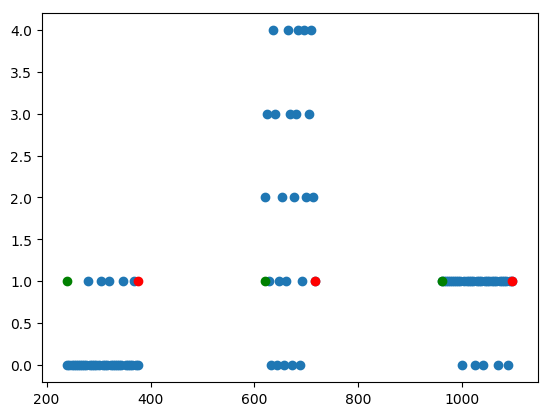

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/stednitz/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


10-element Vector{Int64}:
  256
  272
  312
  352
  360
  960
  968
 1032
 1072
 1096

In [9]:
scatter(stimtimes,stim_seq)

block_edges = Array{Int64}(undef,3,2)
b_ctr = 1
block_edges[1,1] = stimtimes[1]
block_edges[3,2] = stimtimes[end]
flag = 0
for s = 2:length(stimtimes)-1
    isi_now = stimtimes[s+1]-stimtimes[s]
    if isi_now > isi
        block_edges[b_ctr,2] = stimtimes[s]
        b_ctr+=1
        flag = 1
    end
    if flag == 1 && isi_now == isi
        block_edges[b_ctr,1] = stimtimes[s]
        flag = 0
    end
end

for b = 1:3
    scatter(block_edges[b,1],1,color="green")
    scatter(block_edges[b,2],1,color="red")
end

oddball_times = []
oddball_1st = []
oddball_2nd = []

for i = 1:35
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(oddball_times,stimtimes[i])
        append!(oddball_1st,stimtimes[i])
    end
end

for i = length(stimtimes)-35:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 0
        append!(oddball_times,stimtimes[i])
        append!(oddball_2nd,stimtimes[i])

    end
end

f1_times = []
f2_times = []
for i = 1:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(f1_times,stimtimes[i])
    end
end

ms_f1_times = []
ms_f2_times = []
ms_f3_times = []
ms_f4_times = []
ms_f5_times = []

for i = findall((stimtimes .>= block_edges[2,1]) .&& (stimtimes .<= block_edges[2,2]))
    curr_stim = stim_seq[i[2]]
    if curr_stim == 1
        append!(ms_f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(ms_f1_times,stimtimes[i])
    elseif curr_stim == 2
        append!(ms_f3_times,stimtimes[i])
    elseif curr_stim == 3
        append!(ms_f4_times,stimtimes[i])
    elseif curr_stim == 4
        append!(ms_f5_times,stimtimes[i])
    end
end

rng1 = Int(block_edges[1,1]):isi*2:Int(block_edges[1,2])
rng2 = Int(block_edges[3,1]):isi*2:Int(block_edges[3,2])

randtimes = vcat(sort(sample(rng1,5,replace=false)),sort(sample(rng2,5,replace=false)))

r1 = collect(rng1)
rn2 = collect(rng2)
filter!(r1->r1∉oddball_1st,r1)
filter!(rn2->rn2∉oddball_2nd,rn2)

#offset_1 = sort(rand(r1,5))
offset_1 = sort(sample(r1, 5, replace=false))
offset_2 = sort(sample(rn2,5,replace=false))
offset_all = vcat(offset_1,offset_2)

In [10]:
stim_freqs

5-element Vector{Float64}:
  531.0
 1189.0
  355.0
  794.0
 1778.0

### Compute regressors

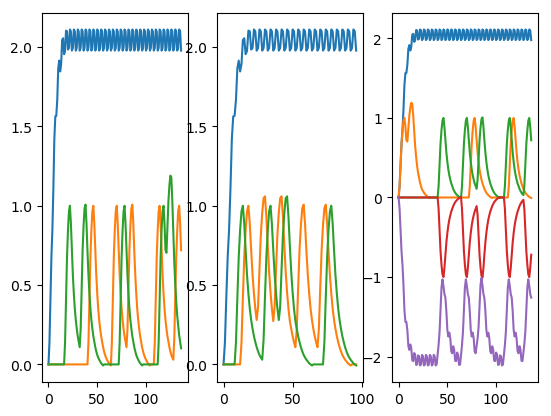

10-element Vector{String}:
 "auditory"
 "oddball"
 "oddball_offset"
 "random"
 "freq1"
 "freq2"
 "ob_1st"
 "ob_2nd"
 "ob_1st_offset"
 "ob_2nd_offset"

In [11]:
function compute_calcium(times)
    reg = zeros((n_frames))
    for stim in times
        nd = stim + length(spike)
        off = 0
        if length(reg) < stim+length(spike) 
            off = nd - length(reg)
            nd = length(reg)
        end
        reg[stim:nd-1] .+= spike[1:end-off]
    end
    return reg
end

auditory_reg = compute_calcium(stimtimes)
oddball_reg = compute_calcium(oddball_times)
oddball_offset_reg = compute_calcium(offset_all)
random_reg = compute_calcium(randtimes)

f1_reg = compute_calcium(f1_times)
f2_reg = compute_calcium(f2_times)

ms_f1_reg = compute_calcium(ms_f1_times)
ms_f2_reg = compute_calcium(ms_f2_times)

ob1_reg = compute_calcium(oddball_1st)
ob2_reg = compute_calcium(oddball_2nd)

ob1_offset_reg = compute_calcium(offset_1)
ob2_offset_reg = compute_calcium(offset_2)

subplot(131)
rng = block_edges[1,1]:block_edges[1,2]
plot(auditory_reg[rng])
plot(oddball_reg[rng])
plot(oddball_offset_reg[rng])

subplot(132)
rng = block_edges[2,1]:block_edges[2,2]
plot(auditory_reg[rng])
plot(f1_reg[rng])
plot(f2_reg[rng])

subplot(133)
rng = block_edges[3,1]:block_edges[3,2]
plot(auditory_reg[rng])
plot(oddball_offset_reg[rng])
plot(oddball_reg[rng])
plot(.-f1_reg[rng])
plot(.-f2_reg[rng])

exp_regs = [auditory_reg,oddball_reg,oddball_offset_reg,random_reg,f1_reg,f2_reg,ob1_reg,ob2_reg,ob1_offset_reg,ob2_offset_reg]#,motion_reg]
reg_titles = ["auditory","oddball","oddball_offset","random","freq1","freq2","ob_1st","ob_2nd","ob_1st_offset","ob_2nd_offset"]#,"motion"]

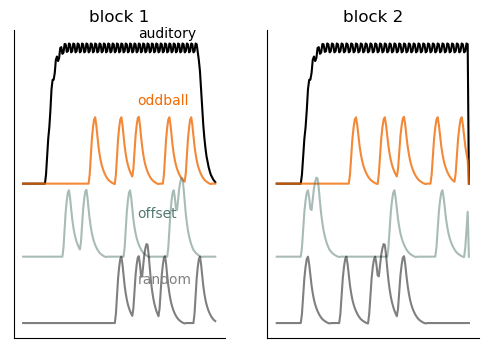

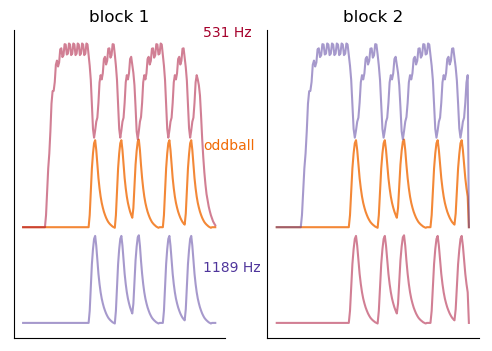

Any[]

In [12]:
figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 105
text(xpos,2.2,"auditory",color="black")
text(xpos,1.2,"oddball",color=colors[1])
text(xpos,-0.5,"offset",color=colors[2])
text(xpos,-1.5,"random",color="gray")

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
#plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f1_reg[rng],color=colors[3],alpha=0.5)
plot(f2_reg[rng].-1.1,color=colors[4],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 165
text(xpos,2.2,"531 Hz",color=colors[3])
text(xpos,0.9,"oddball",color=colors[1])
text(xpos,-0.5,"1189 Hz",color=colors[4])
#text(xpos,-1.5,"random",color=colors[4])

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f2_reg[rng],color=colors[4],alpha=0.5)
plot(f1_reg[rng].-1.1,color=colors[3],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

In [12]:
#for i =1:total_rois
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs),total_rois); fill!(pvals,NaN)

t = now()
print("starting $t ...")
for i = 1:total_rois
    reg_ctr = 1
    yr = DF[i,:]
    for r = 1:length(exp_regs)
        t = now()
        xr = exp_regs[r]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s[reg_ctr,i] = r2(ols)
        coeffs[reg_ctr,i] = coef(ols)[2]
        pvals[reg_ctr,i] = coeftable(ols).cols[4][2]
        reg_ctr +=1
    end
end
t = now()
print("...complete $t")

LoadError: UndefVarError: exp_regs not defined

In [ ]:
short_id = file_list[pnum][length(drv)+17:end-4]
outfile = outpath*short_id*".h5"
if isfile(outfile) rm(outfile) end
of = h5open(outfile,"w")

for r=1:length(exp_regs)
    create_group(of,reg_titles[r])
    of[reg_titles[r]]["reg"] = exp_regs[r]
    of[reg_titles[r]]["r2"] = r2s[r,:]
    of[reg_titles[r]]["coef"] = coeffs[r,:]
    of[reg_titles[r]]["pval"] = pvals[r,:]
end

close(of)

In [14]:
exp_regs = [auditory_reg,oddball_reg,oddball_offset_reg,random_reg,f1_reg,f2_reg,ob1_reg,ob2_reg,ob1_offset_reg,ob2_offset_reg]#,motion_reg]

10-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.0995526962383515, 1.978030190476769, 1.9943201006071474, 2.111279517549821, 2.0995526962383515, 1.978030190476769, 1.9943201006071474, 2.111279517549821, 2.0995526962383515, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.6762969962076263, 0.8407451503692365, 0.9652729118260452, 1.0, 0.8868389098895824, 0.71948580820054, 0.5647033442172837, 0.446770218024352, 0.35194455097519445, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.043311549443966584, 0.02958976547069764, 0.0185965212811607, 0.007100192809040859, 5.866984883284147e-5, -0.006766049610648217, 0.13856961318535252, 0.41968166904719506, 0.6762383263587934, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.6762969962076263, 0.8407451503692365, 0.9652729118260452, 1.0, 0.8868389098895824, 0.719485

### Read in the data if you already have it

In [13]:
short_id = file_list[pnum][length(drv)+17:end-4]
outfile = outpath*short_id*".h5"

of = h5open(outfile,"r")
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs),total_rois); fill!(pvals,NaN)
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

for r=1:length(exp_regs)
    exp_regs[r] = of[reg_titles[r]]["reg"][]
    #temp = of[reg_titles[r]]["r2"][]
    r2s[r,:] .= of[reg_titles[r]]["r2"][]
    coeffs[r,:] .= of[reg_titles[r]]["coef"][]
    pvals[r,:] .= of[reg_titles[r]]["pval"][]
    push!(sig_rois, of[reg_titles[r]]["sig_rois"][])
    push!(nonsig_rois, of[reg_titles[r]]["nonsig_rois"][])
end
close(of)

In [12]:
figure(figsize=(10,4))

subplot(121)

plot(exp_regs[4],color="black")
plot(exp_regs[3].-1,color=colors[2])
plot(exp_regs[2].-2,color=colors[1])
xlim(200,400)

subplot(122)

plot(exp_regs[4],color="black")
plot(exp_regs[3].-1,color=colors[2])
plot(exp_regs[2].-2,color=colors[1])
xlim(900,1100)

LoadError: UndefVarError: exp_regs not defined

In [13]:
[259,260,261,262,263,278,294,990,1086]

9-element Vector{Int64}:
  259
  260
  261
  262
  263
  278
  294
  990
 1086

### Detect significant ROIs (p < .001/total ROIs && R^2 > 99th percentile)

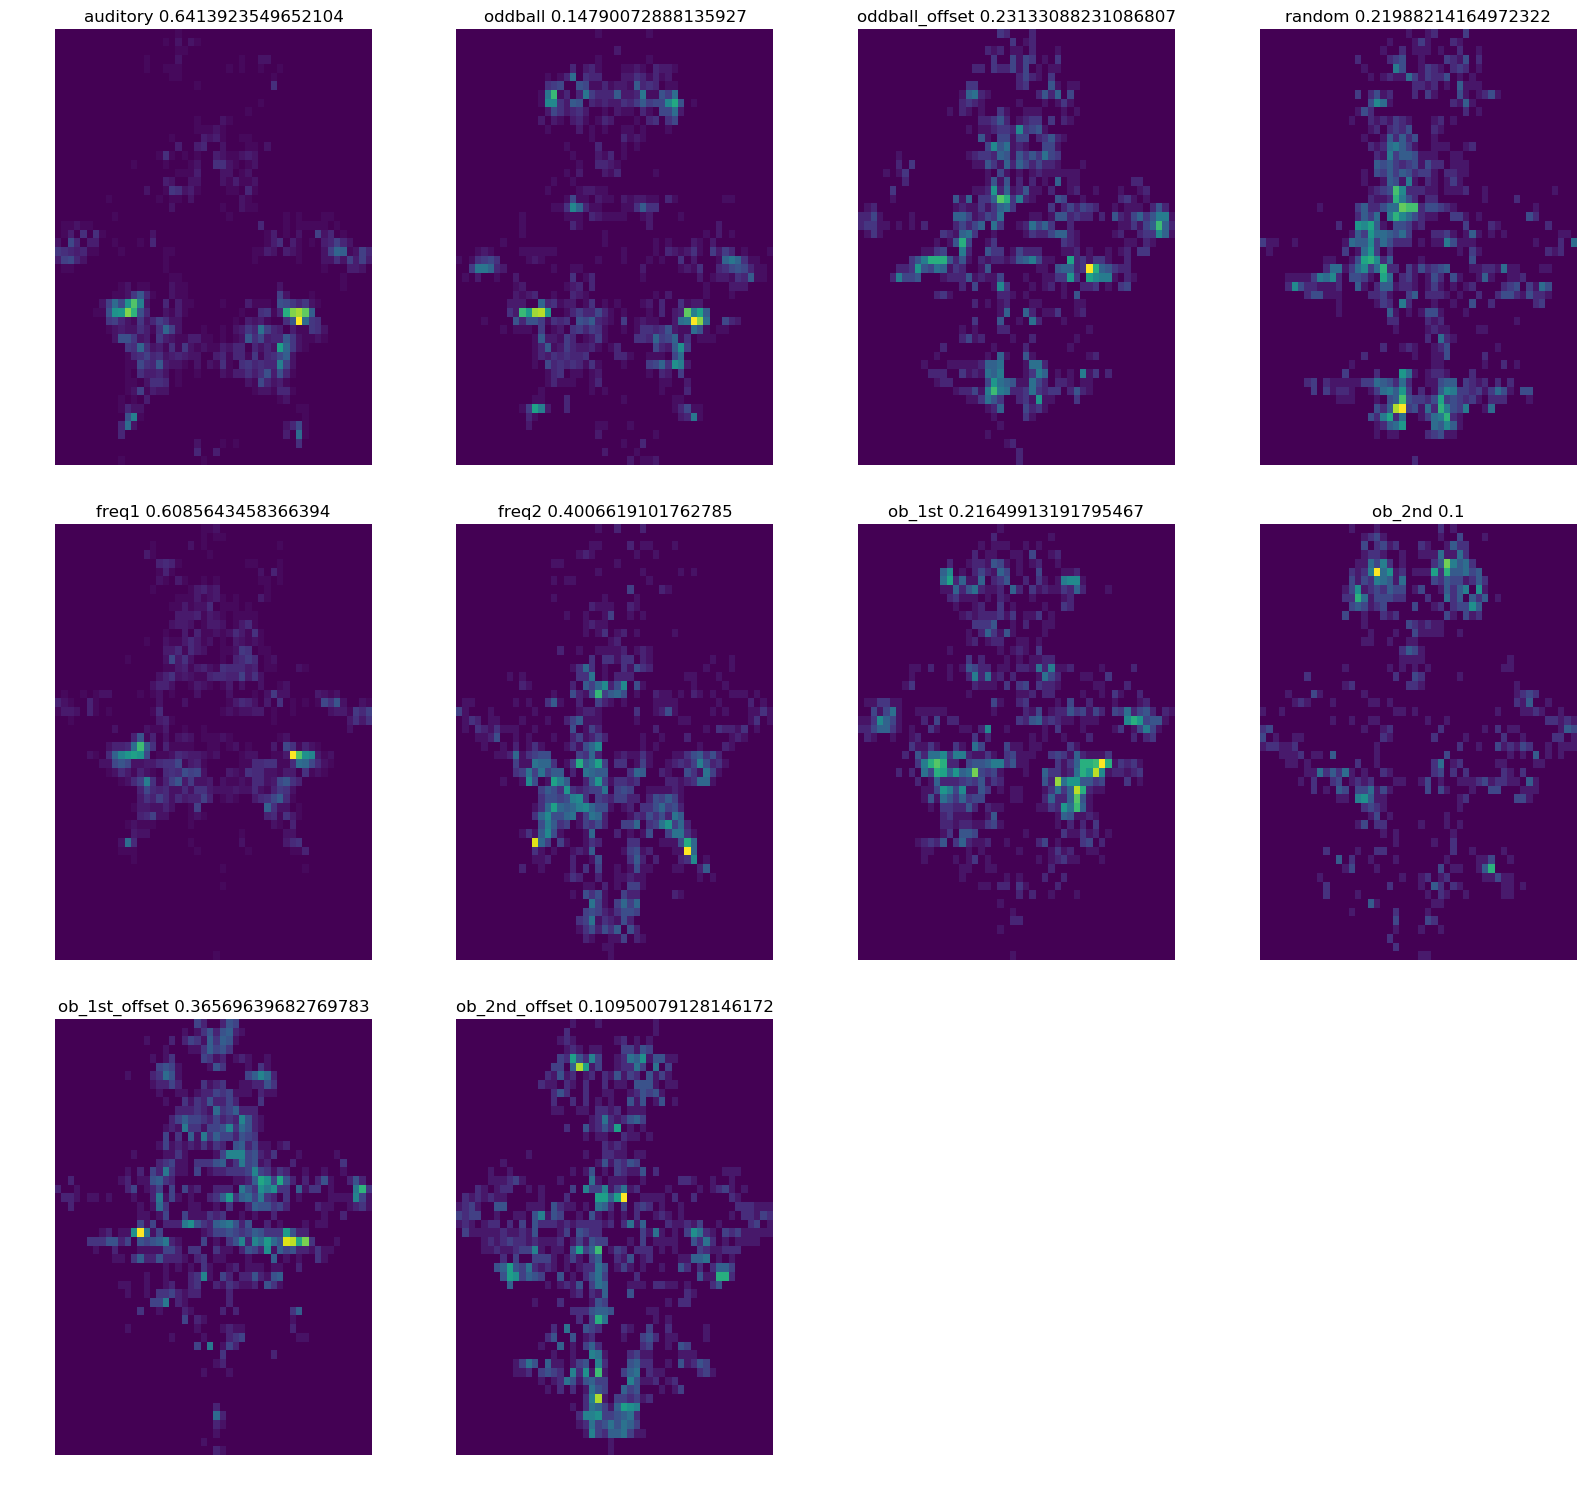

In [15]:
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

rows,cols=3,4
figure(figsize=(cols*4,rows*5)); 

alpha_cutoff = 0.001/total_rois
minimum_r2 = 0.1
perc_cutoff = 99
for r=1:length(exp_regs)
    pvals_clean = pvals[r,:]
    sig_roi_pval = findall(pvals_clean .< alpha_cutoff); #idx_rest_pval = findall(pvals_clean .>= alpha_cutoff)
    
    r2s_clean = replace(r2s[r,:],NaN=>0)
    perc_99 = percentile(r2s_clean,perc_cutoff)
    if perc_99 < minimum_r2 perc_99 = minimum_r2 end
    
    sig_roi_r2 = findall(r2s_clean .> perc_99); #idx_rest_r2 = findall(r2s_clean .<= percentile(r2s_clean,perc_99))
    
    sig_roi = intersect(sig_roi_pval,sig_roi_r2)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sig_roi[1])

    push!(sig_rois,sig_roi)
    push!(nonsig_rois,nonsig_roi)
    subplot(rows,cols,r)
    title(reg_titles[r]*" $perc_99")
    plt.hist2d(centroids[sig_roi,2],centroids[sig_roi,1],bins=50); axis("off");
end

tight_layout()

### Exclude overlapping ROIs

In [16]:
no_overlap_sig = Array{Int64}[]
no_overlap_nonsig = Array{Int64}[]

exclude = copy(unique(vcat(sig_rois[9,:][1],sig_rois[10,:][1],sig_rois[5,:][1],sig_rois[6,:][1])))

for i in [7,8]
    sr = copy(sig_rois[i,:][1])
    del_idx = []
    for s = 1:length(sr)
        if (sr[s] in exclude) == true
            append!(del_idx,s)
        end
    end
    
    deleteat!(sr,del_idx)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sr)
    
    push!(no_overlap_sig,sr)
    push!(no_overlap_nonsig,nonsig_roi)
    
    push!(sig_rois,sr)
    push!(nonsig_rois,sr)
end

In [119]:
of = h5open(outfile,"r+")
##of["centroids"] = centroids
#of["idx_fish"] = idx_fish
for r=1:length(exp_regs)    
    #of[reg_titles[r]]["sig_rois"] = sig_rois[r,:][1]
    #of[reg_titles[r]]["nonsig_rois"] = nonsig_rois[r,:][1]
    labels = ["no_overlap_sig","no_overlap_nonsig"]
    for label in labels
        if haskey(of[reg_titles[r]],label) == true
            delete_object(of[reg_titles[r]][label])
        end
    end
    of[reg_titles[r]]["no_overlap_sig"] = sig_rois[r,:][1]
    of[reg_titles[r]]["no_overlap_nonsig"] = nonsig_rois[r,:][1]
end
#close(of)

In [16]:
n_fish = length(unique(idx_fish))

12

In [134]:
using PyCall
@pyimport matplotlib.colors as matcolors

cool_cmap = matcolors.LinearSegmentedColormap.from_list("cool", (
                 (0.000, (.996, .945, .894)),
                 (0.250, (0.914, 0.416, 0.165)),
                 (0.500, (0.605, 0.106, 0.784)),
                 (0.750, (0.04, 0.490, 0.486)),
                 (1.000, (0, 0, 0))))

In [18]:
using PyCall
@pyimport matplotlib.colors as matcolors

bwr_black = matcolors.LinearSegmentedColormap.from_list("bwr_black", (
                 (0.000, (0.298, 0.443, 1.000)),
                 (0.250, (0.000, 0.145, 0.702)),
                 (0.500, (0.000, 0.000, 0.000)),
                 (0.750, (0.780, 0.012, 0.051)),
                 (1.000, (0.988, 0.290, 0.325))))

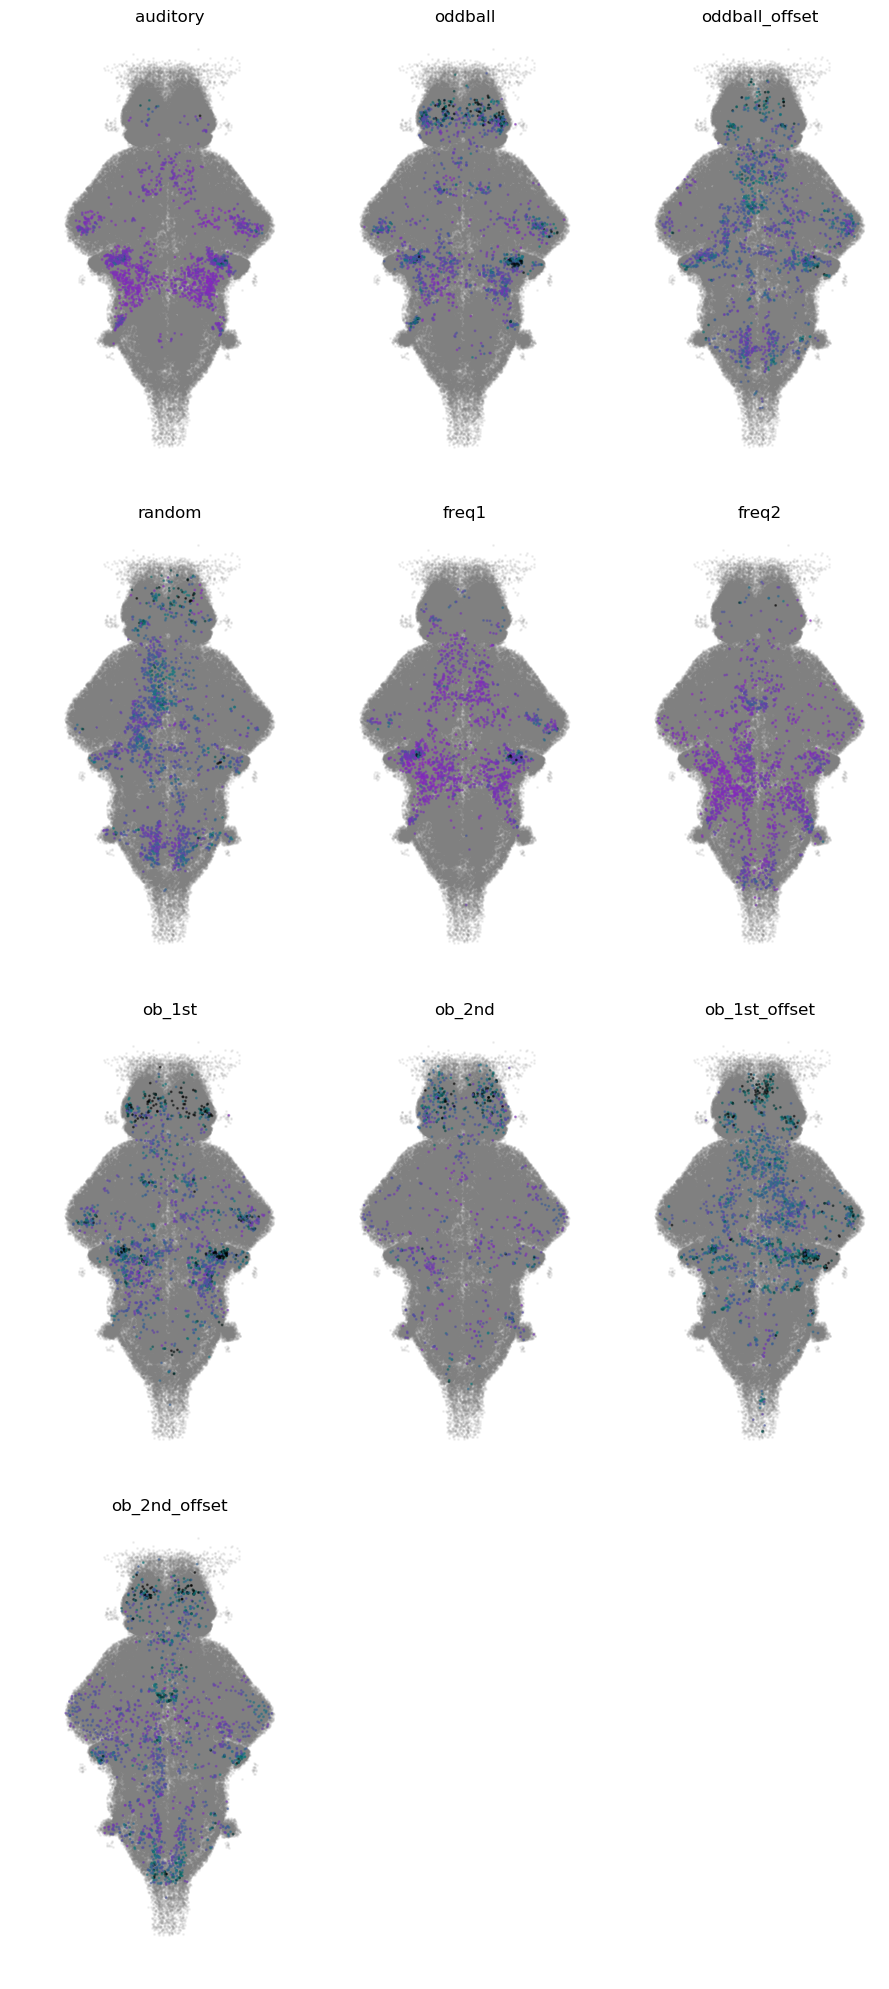

In [21]:
rows,cols=4,3
figure(figsize=(cols*3,rows*5)); 

r=1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    subplot(rows,cols,r); axis("off")
    title(reg_titles[r])
    co = (coeffs[r,sr])
    scatter(centroids[nr,2],centroids[nr,1],color="gray",s=1,alpha=0.1)
    scatter(centroids[sr,2],centroids[sr,1],c=co,cmap=cool_cmap,s=1,alpha=0.5,vmin=-0.3,vmax=0.3)
end

tight_layout()

In [70]:
n_fish = length(unique(idx_fish))
n_rois = length(DF[:,1])
n_frames = length(DF[1,:])
fs = 14

14

# Figure 1

## Figure 1E

In [256]:
sr = collect(1:n_rois)
avg = vec(mean(DF[sr,:],dims=1))
stdev = vec(std(DF[sr,:],dims=1))./n_fish
IJulia.clear_output()

0

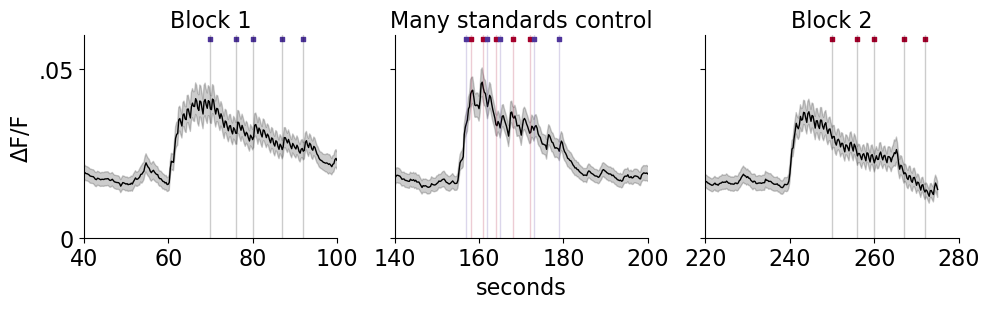

In [258]:
figure(figsize=(10,3.2))
ax1 = subplot(131); ax2 = subplot(132); ax3 = subplot(133)

ymax = 0.06
x = collect(1:n_frames)./fps
for t = 1:3
    axes = [ax1,ax2,ax3]
    subplot(1,3,t)
    fill_between(x, avg.-stdev, avg.+stdev,color="black",alpha=0.2)
    plot(x,avg,color="black",linewidth=1)
end

subplot(131); title("Block 1",fontsize=fs)
for ob in oddball_1st
    scatter(ob/fps,ymax-0.001,color=colors[4],marker="s",s=6)
end

xlim(200/fps,400/fps)

subplot(132); title("Many standards control",fontsize=fs)
for ob in ms_f1_times
    axvline(ob/fps,0,1,color=colors[3],linewidth=1,alpha=0.2)
    scatter(ob/fps,ymax-0.001,color=colors[3],marker="s",s=6)
end

for ob in ms_f2_times
    axvline(ob/fps,0,1,color=colors[4],linewidth=1,alpha=0.2)
    scatter(ob/fps,ymax-0.001,color=colors[4],marker="s",s=6)
end

xlim(575/fps,775/fps)

subplot(133); title("Block 2",fontsize=fs)

for ob in oddball_2nd
    scatter(ob/fps,ymax-0.001,color=colors[3],marker="s",s=6)
end
xlim(900/fps,1100/fps)

ax1.set_ylabel("ΔF/F",fontsize=fs)
ax1.set_yticks([0,0.05,0.1,0.15,0.2])
ax1.set_yticklabels(["0",".05"],fontsize=fs)
ax1.set_xticks([40,60,80,100])

ax2.set_yticks([0,0.05,0.1,0.15,0.2])
ax2.set_yticklabels(["","","","",""])
ax2.set_xticks([140,160,180,200])
ax2.set_xlabel("seconds",fontsize=fs)
ax3.set_yticks([0,0.05,0.1,0.15,0.2])
ax3.set_yticklabels(["","","","",""])
ax3.set_xticks([220,240,260,280])

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,0.06)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.tick_params(axis="x",labelsize=fs)
    for ob in oddball_times
        ax.axvline(ob/fps,0,1,color="black",linewidth=1,alpha=0.2)
    end
end

PyPlot.plt.subplots_adjust(wspace=0,hspace=0)
tight_layout()

plt.savefig("figs/Fig1E.svg",dpi=300)

# Figure 2

## Figure 2A

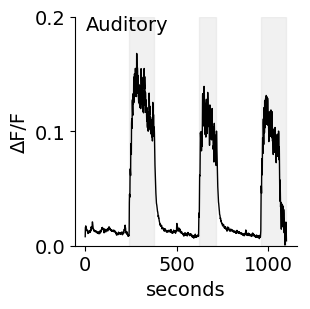

In [100]:
#figure(figsize=(10,10)); 
#rows,cols=4,3

figure(figsize=(3.2,3.2))
ax = subplot(111)

ctr = 1
cctr = 3
titles = ["Auditory","531 Hz","1148 Hz"]

r = 1
sr = sig_rois[r,:][1]
avg = vec(mean(DF[sr,:],dims=1))
stdev = vec(std(DF[sr,:],dims=1))./length(sr)
plot(avg,color="black",linewidth=1)
ax1.fill_between(collect(1:length(avg)), avg.-stdev, avg.+stdev,color="black",alpha=0.2,edgecolor="none")
text(5,0.2.-(ctr*0.012),titles[ctr],color="black",fontsize=fs)


for t = 1:3
    edge = block_edges[t,:]
    ax.axvspan(edge[1], edge[2], alpha=0.3, color="lightgray")
end

ax.set_ylim(0,0.2)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.tick_params(axis="x",labelsize=fs)
ax.set_yticks([0,0.1,0.2])
ax.set_yticklabels([0,0.1,0.2],fontsize=fs)
#ax.set_xticks([0,250,500,750,100])
#ax.set_xticklabels([0,250,500,750,100],fontsize)

ax.set_ylabel("ΔF/F",fontsize=fs)
ax.set_xlabel("seconds",fontsize=fs)

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

plt.savefig("figs/Fig2A.svg",dpi=300)

In [121]:
ymn = 300
ymx = 1270
xmn = 0
xmx = 600

600

## Figure 2B

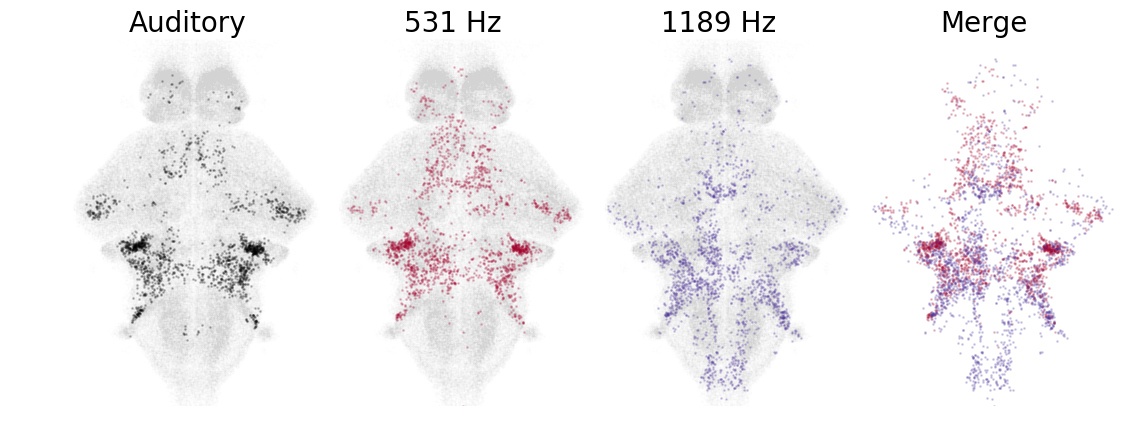

In [122]:
figure(figsize=(11.5,4.5)); 
a = 0.2

titles = ["Auditory","531 Hz","1189 Hz","Merge"]

sr1 = sig_rois[1,:][1]
nr1 = nonsig_rois[1,:][1]
nr2 = nonsig_rois[5,:][1]
sr2 = sig_rois[5,:][1]
nr3 = nonsig_rois[6,:][1]
sr3 = sig_rois[6,:][1]

ax1 = subplot(141); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color="black",s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr],fontsize=20)
    ctr+=1
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

plt.savefig("figs/Fig2B.png",dpi=300)

## Figure 2C

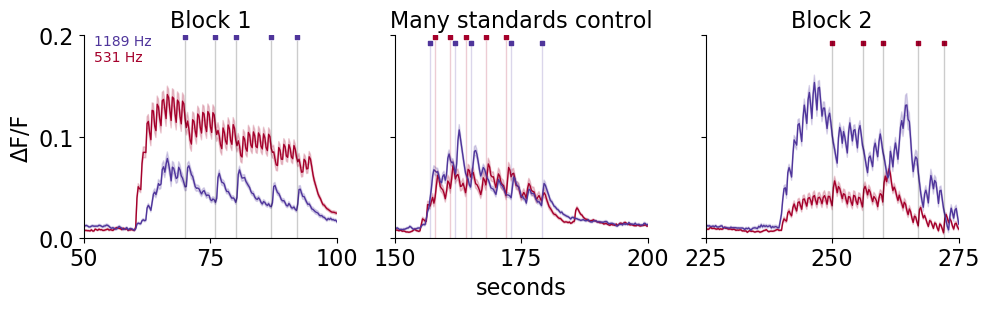

In [239]:
figure(figsize=(10,3.2))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

ymax = 0.2
stim_adj = 0.002

for t = 1:3
ctr = 3

axes = [ax1,ax2,ax3]
subplot(1,3,t)
    for r in [5,6]
        sr = sig_rois[r,:][1]
        nr = nonsig_rois[r,:][1]
        avg = vec(mean(DF[sr,:],dims=1))
        stdev = vec(std(DF[sr,:],dims=1))./n_fish
        fill_between(x, avg.-stdev, avg.+stdev,color=colors[ctr],alpha=0.2)
        plot(x,avg,color=colors[ctr],linewidth=1)
        ctr+=1
    end

end

subplot(131); title("Block 1",fontsize=fs)
text(52,0.175,"531 Hz",color=colors[3])
text(52,0.19,"1189 Hz",color=colors[4])

for ob in oddball_1st
    scatter(ob/fps,ymax-stim_adj,color=colors[4],marker="s",s=6)
end

xlim(200/fps,400/fps)

subplot(132); title("Many standards control",fontsize=fs)
for ob in ms_f1_times
    axvline(ob/fps,0,0.97,color=colors[3],linewidth=1,alpha=0.2)
    scatter(ob/fps,ymax-stim_adj,color=colors[3],marker="s",s=6)
end

for ob in ms_f2_times
    axvline(ob/fps,0,0.97,color=colors[4],linewidth=1,alpha=0.2)
    scatter(ob/fps,ymax-stim_adj*4,color=colors[4],marker="s",s=6)
end

xlim(575/fps,775/fps)

subplot(133); title("Block 2",fontsize=fs)

for ob in oddball_2nd
    scatter(ob/fps,ymax-stim_adj*4,color=colors[3],marker="s",s=5)
end
xlim(900/fps,1100/fps)

ax1.set_ylabel("ΔF/F",fontsize=fs)
ax1.set_yticks([0,0.1,0.2])
ax1.set_yticklabels([0,0.1,0.2],fontsize=fs)
ax1.set_xticks([50,75,100])

ax2.set_yticks([0,0.1,0.2])
ax2.set_yticklabels(["","",""])
ax2.set_xticks([150,175,200])
ax2.set_xlabel("seconds",fontsize=fs)
ax2.set_xlim(150,200)

ax3.set_yticks([0,0.1,0.2])
ax3.set_yticklabels(["","",""])
ax3.set_xticks([225,250,275])

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,ymax)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.tick_params(axis="x",labelsize=fs)

    for ob in oddball_times
        ax.axvline(ob/fps,0,0.97,color="black",linewidth=1,alpha=0.2)
    end
end


PyPlot.plt.subplots_adjust(wspace=0,hspace=0)
tight_layout()

plt.savefig("figs/Fig2C.svg",dpi=300)

## Figure 2D

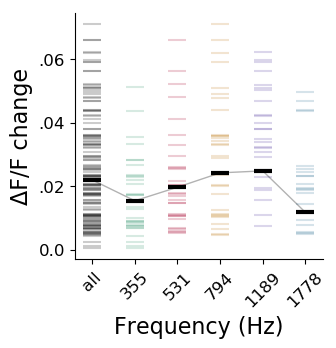

In [247]:
figure(figsize=(3.2,3.2))
ax = subplot(111)
col2 = ["black",colors[3],colors[4]]

r = 1
function max_df_change(sr,times)
    avg_all = []
    for stim in times
        y = DF[sr,stim:stim+isi]
        avg = median(y[2:end].- y[1])
        if avg > 0 append!(avg_all,avg) end
        #append!(avg_all,avg)
    end
    return avg_all
end

totals = zeros((6))

for fish in unique(idx_fish)
    ctr = 1
    valid_idx = findall(idx_fish[1,:] .== fish)
    sr = sig_rois[1,:][1]
    sr = intersect(sr,valid_idx)

    avg_all = max_df_change(sr,vcat(ms_f1_times,ms_f2_times,ms_f3_times,ms_f4_times,ms_f5_times))
    avg_f1 = max_df_change(sr,ms_f1_times)
    avg_f2 = max_df_change(sr,ms_f2_times)
    avg_f3 = max_df_change(sr,ms_f3_times)
    avg_f4 = max_df_change(sr,ms_f4_times)
    avg_f5 = max_df_change(sr,ms_f5_times)

    col2 = ["black",[55,151,113]./255,colors[3],[191,124,25]./255,colors[4],[54,118,152]./255]
    ctr = 1
    for avgs in [avg_all,avg_f3,avg_f1,avg_f4,avg_f2,avg_f5]
        try
        for avg in avgs 
            scatter(ctr,avg,color=col2[ctr],marker="_",s=150,alpha=0.2)
        end
        totals[ctr] += mean(avgs)
        catch
            continue
        end
        ctr+=1
    end
end
    
totals = totals./n_fish
for i = 1:6
    scatter(i,totals[i],color="black",marker="_",s=150,linewidth=3)
    if i < 6
        plot([i,i+1],[totals[i],totals[i+1]],color="black",linewidth=1,alpha=0.3)
    end
end

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ylabel("ΔF/F change",fontsize=fs)
xticks(collect(1:6),vcat(["all"],sort(Int.(stim_freqs))),rotation = 45,fontsize=12)

ax.tick_params(axis="x",labelsize=12)
ax.set_yticks([0,0.02,0.04,0.06])
ax.set_yticklabels(["0.0",".02",".04",".06"],fontsize=12)
xlabel("Frequency (Hz)",fontsize=fs)

PyPlot.plt.subplots_adjust(wspace=0,hspace=0)
#tight_layout()

plt.savefig("figs/Fig2D.svg",dpi=300)

## Figure 2E

In [140]:
plot_data = matopen(drv*"loudness/plot_data.mat","r")
peak_sem = read(plot_data,"peak_sem")
per_fish_data = read(plot_data,"peakdata_fish")

MAT.MAT_v5.Matlabv5File(IOStream(<file /mnt/a82d7171-92f9-48ad-9ba4-aea036c8fec8/data_storage/collabs/maya/oddball/loudness/plot_data.mat>), false, #undef)

In [141]:
keys(plot_data)

KeySet for a Dict{String, Int64} with 6 entries. Keys:
  "peakdata_fish"
  "all_freqs"
  "allvols"
  "peak_sem"
  "peak_std"
  "freq_c"

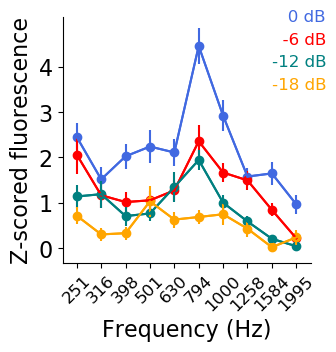

In [246]:
figure(figsize=(3.2,3.2))
ax = subplot(111)

cols = ["royalblue","red","teal","orange"]
avgs = zeros((10))

for l = 1:4
    col = cols[l]
    for f = 1:10
        avg = mean(vec(per_fish_data[l,:,f]),dims=1)
        avgs[f] = avg[1]
        scatter(f,avg,color=col)
        if f < 10
            next_avg = mean(vec(per_fish_data[l,:,f+1]),dims=1)
            plot([f,f+1],[avg,next_avg],color=col)
        end
    end
    errorbar(collect(1:10), avgs, yerr=vec(peak_sem[l,:]),color=col)
end

text(9,5,"   0 dB",color=cols[1],fontsize=12)
text(9,4.5,"  -6 dB",color=cols[2],fontsize=12)
text(9,4,"-12 dB",color=cols[3],fontsize=12)
text(9,3.5,"-18 dB",color=cols[4],fontsize=12)

#text(9,4.7,"  0 dB",color=cols[1])
#text(9,4.6,"  0 dB",color=cols[1])


ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ylabel("Z-scored fluorescence",fontsize=fs)
xticks(collect(1:10),[251,316,398,501,630,794,1000,1258,1584,1995],rotation = 45,fontsize=10)
xlabel("Frequency (Hz)",fontsize=fs)

ax.tick_params(axis="x",labelsize=12)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels([0,1,2,3,4],fontsize=fs)

PyPlot.plt.subplots_adjust(wspace=0,hspace=0)
#tight_layout()

plt.savefig("figs/Fig2E.svg",dpi=300)

## Figure 2F

Need to run motion analysis first (below)

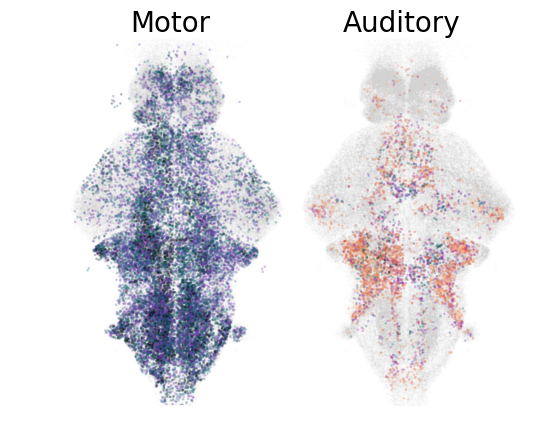

In [139]:
figure(figsize=(5.5,4.5))

cm = cool_cmap
vm = 0.5

ax1 = subplot(121); axis("off"); title("Motor",fontsize=20)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=r2s_mot[sig_mot],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

ax2 = subplot(122); axis("off"); title("Auditory",fontsize=20)
i = vcat(sig_rois[1,:][1],sig_rois[5,:][1],sig_rois[6,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

for ax in [ax1,ax2]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

plt.savefig("figs/Fig2F.png",dpi=300)

# Figure 3

## Figure 3B

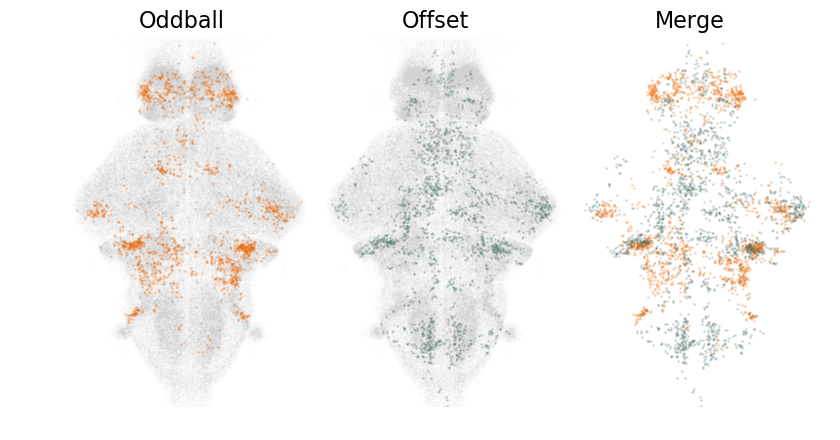

In [204]:
figure(figsize=(8.5,4.5)); 
a = 0.2

fs = 16

titles = ["Oddball","Offset","Merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[3,:][1]
sr2 = sig_rois[3,:][1]

nsa = 0.002

ax1 = subplot(131); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(132); 
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ax3 = subplot(133); 
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr],fontsize=fs)
    ctr+=1
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

savefig("figs/Fig3B.png",dpi=300)

## Figure 3C

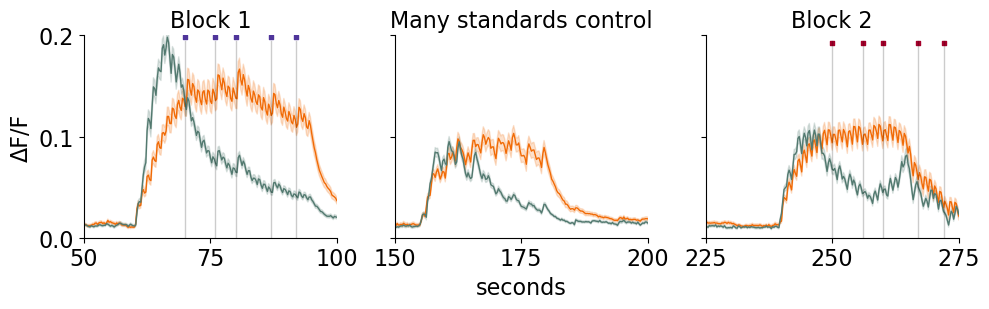

In [227]:
figure(figsize=(10,3.2))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

ymax = 0.2
stim_adj = 0.002

for t = 1:3
ctr = 1

axes = [ax1,ax2,ax3]
subplot(1,3,t)
    for r in [2,3]
        sr = sig_rois[r,:][1]
        nr = nonsig_rois[r,:][1]
        avg = vec(mean(DF[sr,:],dims=1))
        stdev = vec(std(DF[sr,:],dims=1))./n_fish
        fill_between(x, avg.-stdev, avg.+stdev,color=colors[ctr],alpha=0.2)
        plot(x,avg,color=colors[ctr],linewidth=1)
        ctr+=1
    end

end

subplot(131); title("Block 1",fontsize=fs)
#text(52,0.175,"531 Hz",color=colors[3])
#text(52,0.19,"1189 Hz",color=colors[4])

for ob in oddball_1st
    scatter(ob/fps,ymax-stim_adj,color=colors[4],marker="s",s=6)
end

xlim(200/fps,400/fps)

subplot(132); title("Many standards control",fontsize=fs)
#for ob in ms_f1_times
#    axvline(ob/fps,0,0.97,color=colors[3],linewidth=1,alpha=0.2)
#    scatter(ob/fps,ymax-stim_adj,color=colors[3],marker="s",s=6)
#end

#for ob in ms_f2_times
#    axvline(ob/fps,0,0.97,color=colors[4],linewidth=1,alpha=0.2)
#    scatter(ob/fps,ymax-stim_adj*4,color=colors[4],marker="s",s=6)
#end

xlim(575/fps,775/fps)

subplot(133); title("Block 2",fontsize=fs)

for ob in oddball_2nd
    scatter(ob/fps,ymax-stim_adj*4,color=colors[3],marker="s",s=5)
end
xlim(900/fps,1100/fps)

ax1.set_ylabel("ΔF/F",fontsize=fs)
ax1.set_yticks([0,0.1,0.2])
ax1.set_yticklabels([0,0.1,0.2],fontsize=fs)
ax1.set_xticks([50,75,100])

ax2.set_yticks([0,0.1,0.2])
ax2.set_yticklabels(["","",""])
ax2.set_xticks([150,175,200])
ax2.set_xlabel("seconds",fontsize=fs)

ax2.set_xlim(150,200)
ax3.set_yticks([0,0.1,0.2])
ax3.set_yticklabels(["","",""])
ax3.set_xticks([225,250,275])

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,ymax)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.tick_params(axis="x",labelsize=fs)

    for ob in oddball_times
        ax.axvline(ob/fps,0,0.97,color="black",linewidth=1,alpha=0.2)
    end
end

tight_layout()
#PyPlot.plt.subplots_adjust(wspace=0.2,hspace=0)

plt.savefig("figs/Fig3C.svg",dpi=300)

## Figure 3D

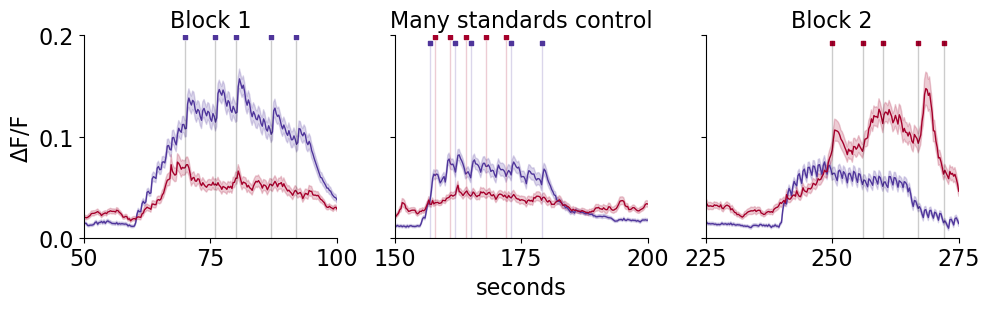

In [228]:
figure(figsize=(10,3.2))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

ymax = 0.2
stim_adj = 0.002

for t = 1:3
ctr = 1

axes = [ax1,ax2,ax3]
subplot(1,3,t)
    for r in [11,12]
        sr = sig_rois[r,:][1]
        nr = nonsig_rois[r,:][1]
        avg = vec(mean(DF[sr,:],dims=1))
        stdev = vec(std(DF[sr,:],dims=1))./n_fish
        fill_between(x, avg.-stdev, avg.+stdev,color=colors[5-ctr],alpha=0.2)
        plot(x,avg,color=colors[5-ctr],linewidth=1)
        ctr+=1
    end

end

subplot(131); title("Block 1",fontsize=fs)
#text(52,0.175,"531 Hz",color=colors[3])
#text(52,0.19,"1189 Hz",color=colors[4])

for ob in oddball_1st
    scatter(ob/fps,ymax-stim_adj,color=colors[4],marker="s",s=6)
end

xlim(200/fps,400/fps)

subplot(132); title("Many standards control",fontsize=fs)
for ob in ms_f1_times
    axvline(ob/fps,0,0.97,color=colors[3],linewidth=1,alpha=0.2)
    scatter(ob/fps,ymax-stim_adj,color=colors[3],marker="s",s=6)
end

for ob in ms_f2_times
    axvline(ob/fps,0,0.97,color=colors[4],linewidth=1,alpha=0.2)
    scatter(ob/fps,ymax-stim_adj*4,color=colors[4],marker="s",s=6)
end

xlim(575/fps,775/fps)

subplot(133); title("Block 2",fontsize=fs)

for ob in oddball_2nd
    scatter(ob/fps,ymax-stim_adj*4,color=colors[3],marker="s",s=5)
end
xlim(900/fps,1100/fps)

ax1.set_ylabel("ΔF/F",fontsize=fs)
ax1.set_yticks([0,0.1,0.2])
ax1.set_yticklabels([0,0.1,0.2],fontsize=fs)
ax1.set_xticks([50,75,100])
#ax1.set_xlim(40,110)

ax2.set_yticks([0,0.1,0.2])
ax2.set_yticklabels(["","",""])
ax2.set_xticks([150,175,200])
ax2.set_xlim(150,200)
ax2.set_xlabel("seconds",fontsize=fs)

ax3.set_yticks([0,0.1,0.2])
ax3.set_yticklabels(["","",""])
ax3.set_xticks([225,250,275])
#ax3.set_xlim(215,285)


ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,ymax)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.tick_params(axis="x",labelsize=fs)

    for ob in oddball_times
        ax.axvline(ob/fps,0,0.97,color="black",linewidth=1,alpha=0.2)
    end
end

tight_layout()
#PyPlot.plt.subplots_adjust(wspace=0.2,hspace=0)

plt.savefig("figs/Fig3D.svg",dpi=300)

## Figure 3E

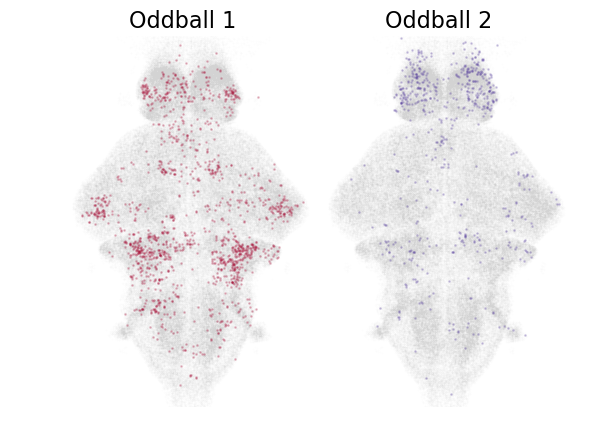

In [252]:
figure(figsize=(6,4.5)); 
a = 0.2

fs = 16

titles = ["Oddball 1","Oddball 2"]#,"Merge"]

sr1 = sig_rois[11,:][1]
nr1 = nonsig_rois[1,:][1]
nr2 = nonsig_rois[1,:][1]
sr2 = sig_rois[12,:][1]

nsa = 0.002

ax1 = subplot(121); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[3],s=1,alpha=a)

ax2 = subplot(122); 
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

#ax3 = subplot(133); 
#scatter(centroids[sr1,2],centroids[sr1,1],color=colors[3],s=1,alpha=a)
#scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2]#,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr],fontsize=fs)
    ctr+=1
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

savefig("figs/Fig3E.png",dpi=300)

## Figure 3F

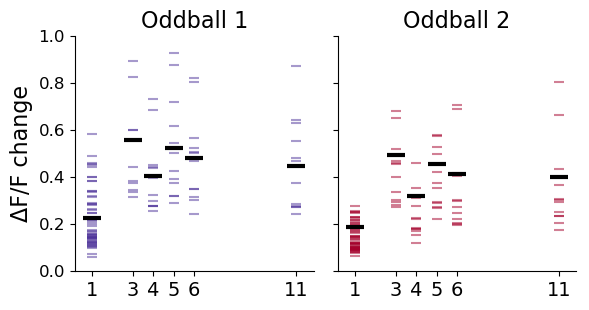

In [251]:
rows,cols = 1,2
figure(figsize=(3*cols,3.2*rows))

ax1 = subplot(rows,cols,1)
ax1.set_ylabel("ΔF/F change",fontsize=fs)
ax2 = subplot(rows,cols,2)

stim_freq = [0,1,1,0]
c_ctr = 1
title_cols = [colors[4],colors[3]]

repetitions = []
possible_repeats = sort([1,5,3,6,4,11])
repetitions = zeros(length(possible_repeats),2)

ob_times = [oddball_1st,oddball_2nd]
ms_times = [ms_f2_times,ms_f1_times]

for r in [11,12]
    for fish in unique(idx_fish)
        valid_idx = findall(idx_fish[1,:] .== fish)
        sr = sig_rois[r,:][1]
        df_per_fish = intersect(sr,valid_idx)

        subplot(rows,cols,c_ctr)
        stims = vcat(ob_times[c_ctr],ms_times[c_ctr])
        for t in 2:length(stimtimes)
            onset = stimtimes[t]
            if (onset in stims) == true
                response = vec(mean(DF[df_per_fish,onset:onset+isi],dims=1))
                response = sum(response) .- response[1]
                prev_stim = stim_seq[t-1]
                curr_stim = stim_seq[t]

                repeats = findfirst(reverse(stim_seq[1:t-2]) .!== prev_stim)
                if isnothing(repeats) == true repeats = 11 end

                r_idx = findall(possible_repeats .== repeats)

                if (isnan(response) == false)
                    repetitions[r_idx,1] .+= 1
                    repetitions[r_idx,2] .+= response
                else 
                    print(repeats)
                end
                scatter(repeats,response,alpha=0.5,color=title_cols[c_ctr],s=50,marker="_")
                #end
            end
        end
    end
    
    for i = 1:size(repetitions)[1]
        y = repetitions[i,2]./repetitions[i,1]
        scatter(possible_repeats[i],y,color="black",s=150,marker="_",linewidth=3)
    end
    
    c_ctr += 1
end
    
titles = ["Oddball 1","Oddball 2"]
ctr = 1

ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax1.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=12)
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticklabels(["","","","","",""])
#ax1.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=12)

for ax in [ax1,ax2]#,ax3,ax4]
    ax.set_ylim(0,1)
    ax.set_title(titles[ctr],color="black",fontsize=fs)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.set_xticks(possible_repeats)
    ax.set_xticklabels(possible_repeats,fontsize=14)

    ctr+=1
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0.1,hspace=0)

plt.savefig("figs/Fig3F.svg",dpi=300)

In [253]:
colors[2].*255

3-element Vector{Float64}:
  82.0
 121.0
 111.0

## Anatomy plots

In [21]:
print("$ymn $ymx $xmn $xmx")

200 1300 0 600

### Oddball/offset

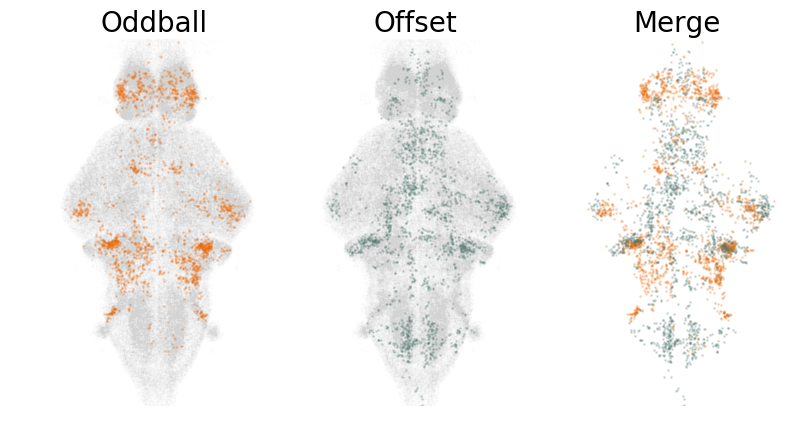

In [39]:
figure(figsize=(8,4.5)); 
#suptitle("1s ISI")
a = 0.2

fst = 20
fs = 16
ymn,ymx = 300,1260
xmn,xmx = 25,590

titles = ["Oddball","Offset","Merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[3,:][1]
sr2 = sig_rois[3,:][1]

nsa = 0.002

ax1 = subplot(131); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(132); 
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ax3 = subplot(133); 
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr],fontsize=fst)
    ctr+=1
end

PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

tight_layout()

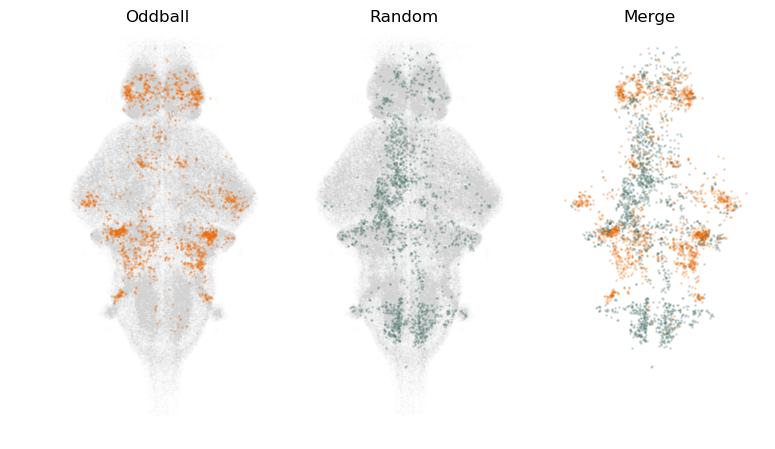

In [15]:
figure(figsize=(9,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["Oddball","Random","Merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[4,:][1]
sr2 = sig_rois[4,:][1]

nsa = 0.002

ax1 = subplot(131); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(132); 
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ax3 = subplot(133); 
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

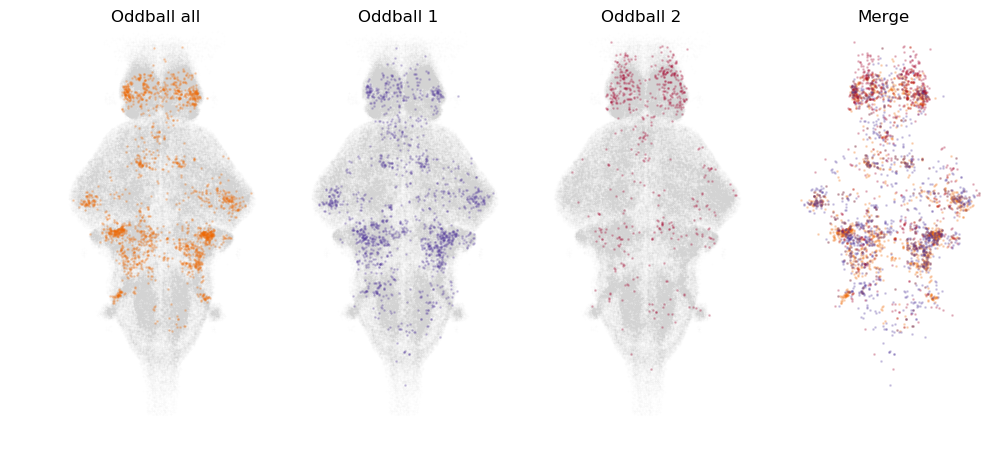

In [614]:
figure(figsize=(12,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["Oddball all","Oddball 1","Oddball 2","Merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]

nr2 = nonsig_rois[2,:][1]
sr2 = sig_rois[11,:][1]
nr3 = nonsig_rois[2,:][1]
sr3 = sig_rois[12,:][1]

ax1 = subplot(141); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

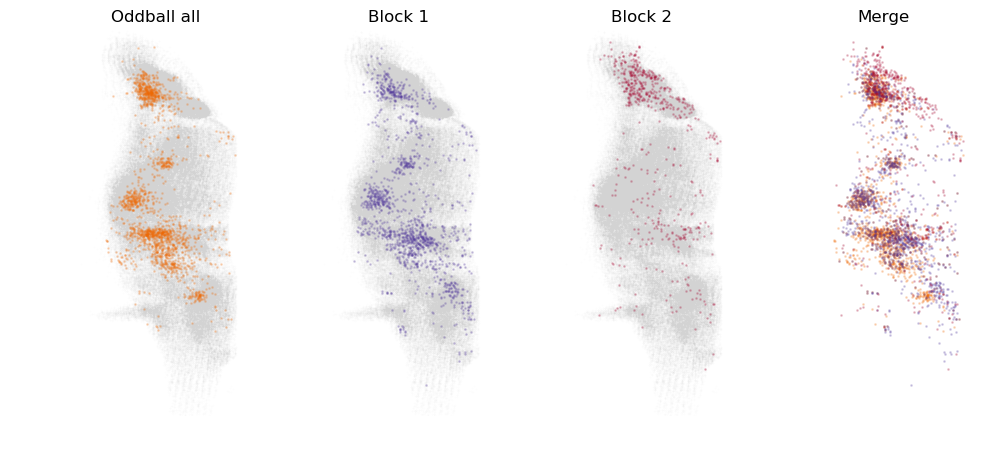

In [ ]:
figure(figsize=(12,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["Oddball all","Block 1","Block 2","Merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]

nr2 = nonsig_rois[2,:][1]
sr2 = sig_rois[11,:][1]
nr3 = nonsig_rois[2,:][1]
sr3 = sig_rois[12,:][1]

ax1 = subplot(141); 
scatter(centroids[nr1,3],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,3],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,3],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,3],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,3],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,3],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[sr1,3],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[sr2,3],centroids[sr2,1],color=colors[4],s=1,alpha=a)
scatter(centroids[sr3,3],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,150)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

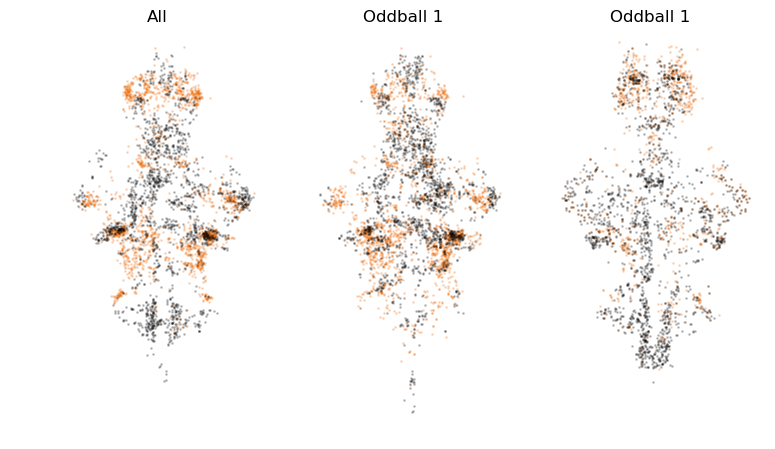

In [618]:
figure(figsize=(9,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["All","Oddball 1","Oddball 1","Merge"]


sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[7,:][1]
sr2 = sig_rois[7,:][1]
nr3 = nonsig_rois[8,:][1]
sr3 = sig_rois[8,:][1]

osr1 = sig_rois[3,:][1]
onr1 = nonsig_rois[3,:][1]
onr2 = nonsig_rois[9,:][1]
osr2 = sig_rois[9,:][1]
onr3 = nonsig_rois[10,:][1]
osr3 = sig_rois[10,:][1]

ax1 = subplot(131); 
#scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[osr1,2],centroids[osr1,1],color="black",s=1,alpha=a)

ax2 = subplot(132);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[1],s=1,alpha=a)
scatter(centroids[osr2,2],centroids[osr2,1],color="black",s=1,alpha=a)

ax3 = subplot(133);
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[1],s=1,alpha=a)
scatter(centroids[osr3,2],centroids[osr3,1],color="black",s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

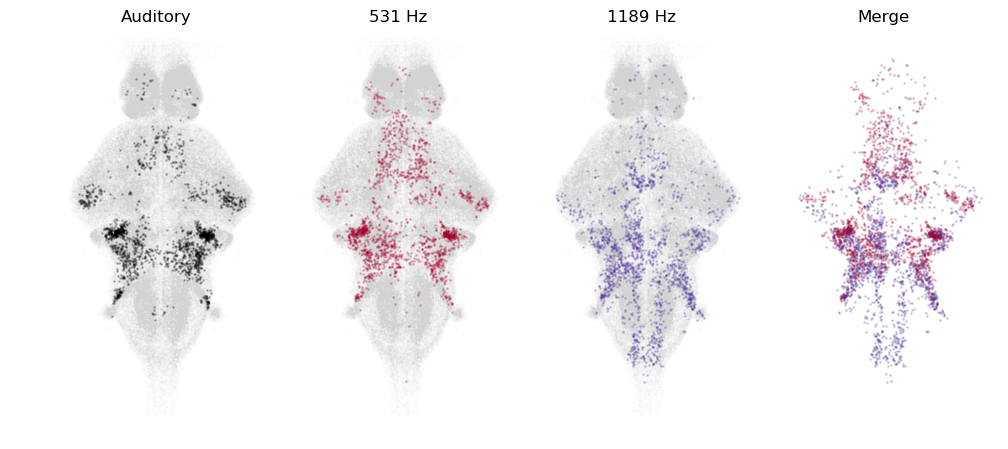

In [619]:
figure(figsize=(12,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["Auditory","531 Hz","1189 Hz","Merge"]

sr1 = sig_rois[1,:][1]
nr1 = nonsig_rois[1,:][1]
nr2 = nonsig_rois[5,:][1]
sr2 = sig_rois[5,:][1]
nr3 = nonsig_rois[6,:][1]
sr3 = sig_rois[6,:][1]

ax1 = subplot(141); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color="black",s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)
#scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

## Motion analysis

### Reset fish indices

In [128]:
fish_list = unique(idx_fish)
n_fish = length(fish_list)
reset_idx = collect(1:n_fish)

reset_idx_fish = copy(idx_fish)
for i in 1:length(idx_fish)
    loc = findall(idx_fish[i] .== fish_list)[1]
    reset_idx_fish[i] = Int.(reset_idx[loc])
end

### Regressor for block-specific motions

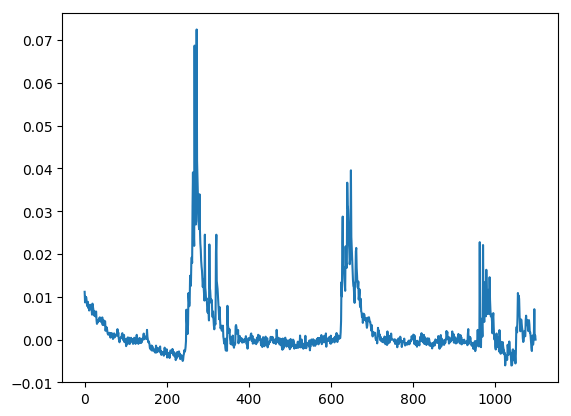

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4fc166b438>

In [129]:
plot(motion_reg[1][:])

In [130]:
mot_1_reg = zeros(n_fish,length(motion_reg[1][:]))
mot_2_reg = zeros(n_fish,length(motion_reg[1][:]))
for i = 1:n_fish
    for stim in oddball_1st
        mot_1_reg[i,stim-1:stim+isi] = motion_reg[i][stim-1:stim+isi]
    end
    
    for stim in oddball_2nd
        mot_2_reg[i,stim-1:stim+isi] = motion_reg[i][stim-1:stim+isi]
    end
end

In [131]:
coeffs_mot = Array{Float32}(undef,total_rois); fill!(coeffs_mot,NaN)
r2s_mot = Array{Float32}(undef,total_rois); fill!(r2s_mot,NaN)
pvals_mot = Array{Float32}(undef,total_rois); fill!(pvals_mot,NaN)

t = now()
print("starting $t ...")
for f = 1:n_fish
    idx = findall(reset_idx_fish[1,:] .== f)
    xr = motion_reg[f][:]
    for i in idx
        yr = DF[i,:]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s_mot[i] = r2(ols)
        coeffs_mot[i] = coef(ols)[2]
        pvals_mot[i] = coeftable(ols).cols[4][2]
    end
end
t = now()
print("...complete $t")

coeffs_mot1 = Array{Float32}(undef,total_rois); fill!(coeffs_mot1,NaN)
r2s_mot1 = Array{Float32}(undef,total_rois); fill!(r2s_mot1,NaN)
pvals_mot1 = Array{Float32}(undef,total_rois); fill!(pvals_mot1,NaN)

t = now()
print("starting $t ...")
for f = 1:n_fish
    idx = findall(reset_idx_fish[1,:] .== f)
    xr = mot_1_reg[f,:]
    for i in idx
        yr = DF[i,:]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s_mot1[i] = r2(ols)
        coeffs_mot1[i] = coef(ols)[2]
        pvals_mot1[i] = coeftable(ols).cols[4][2]
    end
end
t = now()
print("...complete $t")

coeffs_mot2 = Array{Float32}(undef,total_rois); fill!(coeffs_mot2,NaN)
r2s_mot2 = Array{Float32}(undef,total_rois); fill!(r2s_mot2,NaN)
pvals_mot2 = Array{Float32}(undef,total_rois); fill!(pvals_mot2,NaN)

for f = 1:n_fish
    idx = findall(reset_idx_fish[1,:] .== f)
    xr = mot_2_reg[f,:]
    for i in idx
        yr = DF[i,:]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s_mot2[i] = r2(ols)
        coeffs_mot2[i] = coef(ols)[2]
        pvals_mot2[i] = coeftable(ols).cols[4][2]
    end
end
t = now()
print("...complete $t")

starting 2024-03-21T13:19:00.507 ......complete 2024-03-21T13:19:31.659starting 2024-03-21T13:19:31.671 ......complete 2024-03-21T13:19:50.900...complete 2024-03-21T13:20:10.078

### Compute motion-significant ROIs

In [132]:
pvals_clean = pvals_mot[:]
sig_roi_pval = findall(pvals_clean .< alpha_cutoff); #idx_rest_pval = findall(pvals_clean .>= alpha_cutoff)
    
r2s_clean = replace(r2s_mot[:],NaN=>0)
perc_99 = percentile(r2s_clean,90)
print(perc_99)
sig_roi_r2 = findall(r2s_clean .> perc_99)

sig_mot = intersect(sig_roi_pval,sig_roi_r2)
IJulia.clear_output()

0

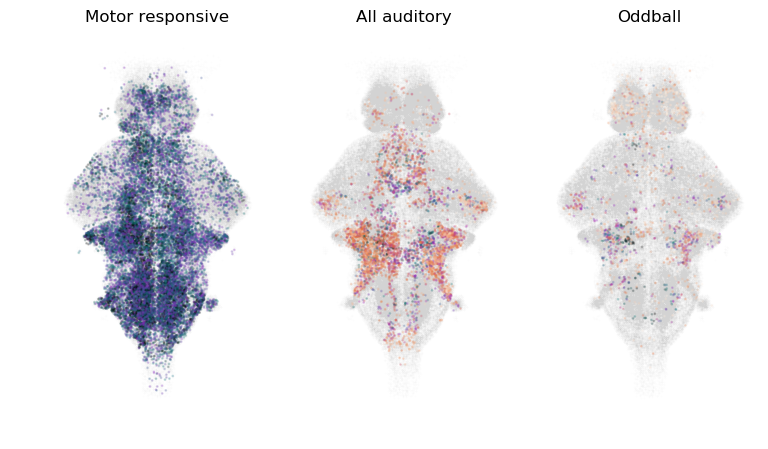

PyObject <matplotlib.collections.PathCollection object at 0x7fa15b8747f0>

In [650]:
figure(figsize=(9,5))

cm = cool
vm = 0.5

subplot(131); axis("off"); title("Motor responsive")
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=r2s_mot[sig_mot],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(132); axis("off"); title("All auditory")
i = vcat(sig_rois[1,:][1],sig_rois[5,:][1],sig_rois[6,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(133); axis("off"); title("Oddball")
i = vcat(sig_rois[11,:][1],sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

In [115]:
figure(figsize=(9,5))

cm = "bwr"
vm = 0.2
subplot(131); axis("off"); title("Motion")
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=coeffs_mot[sig_mot],s=1,cmap=cm,vmin=-vm,vmax=vm,alpha=0.2)

subplot(132); axis("off"); title("All auditory")
i = vcat(sig_rois[1,:][1],sig_rois[5,:][1],sig_rois[6,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=coeffs_mot[i],s=1,cmap=cm,vmin=-vm,vmax=vm,alpha=0.2)

subplot(133); axis("off"); title("All oddball")
i = vcat(sig_rois[11,:][1],sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=coeffs_mot[i],s=1,cmap=cm,vmin=-vm,vmax=vm,alpha=0.2)


LoadError: UndefVarError: sig_mot not defined

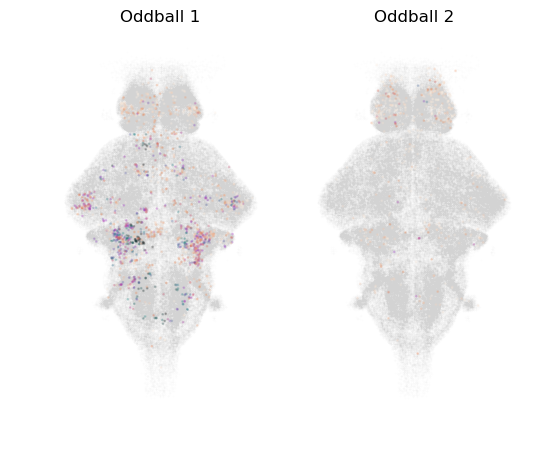

PyObject <matplotlib.collections.PathCollection object at 0x7fa11c124d30>

In [653]:
figure(figsize=(6,5))

cm = cool
vm = 0.5

subplot(121); axis("off"); title("Oddball 1")
i = vcat(sig_rois[11,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=1,cmap=cm,alpha=0.2,vmin=0,vmax=vm)

subplot(122); axis("off"); title("Oddball 2")
i = vcat(sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=1,cmap=cm,alpha=0.2,vmin=0,vmax=vm)

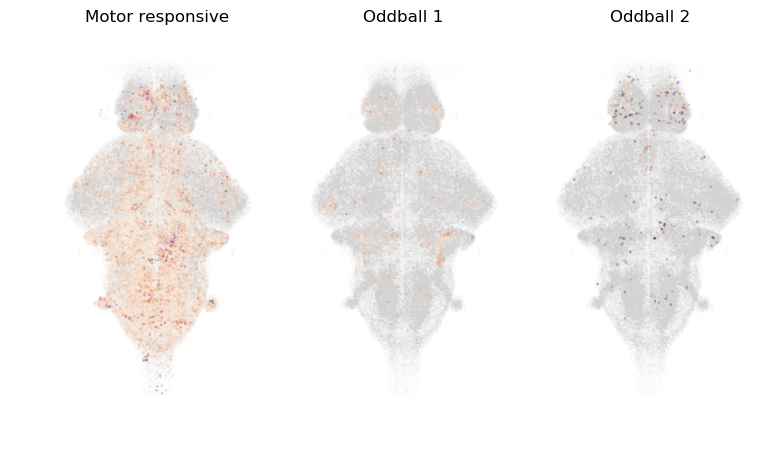

PyObject <matplotlib.collections.PathCollection object at 0x7fa11d83be48>

In [649]:
figure(figsize=(9,5))

cm = cool
vm = 0.05

subplot(131); axis("off"); title("Motor responsive")
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=r2s_mot2[sig_mot],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(132); axis("off"); title("Oddball 1")
i = vcat(sig_rois[11,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot2[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(133); axis("off"); title("Oddball 2")
i = vcat(sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot2[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

### Plot all individual traces + oddball cells from each fish

In [662]:
ctr = 0
cm = PyPlot.cm.get_cmap("gist_stern")
cm_r2 = cool
vm = 0.5

rows,cols = 2,3
figure(figsize=(cols*3,rows*5))
ax1 = subplot(rows,cols,1)
ax2 = subplot(rows,cols,2)
ax3 = subplot(rows,cols,3)
ax4 = subplot(rows,cols,4)
ax5 = subplot(rows,cols,5)
ax6 = subplot(rows,cols,6)

n_fish = size(motion_reg)[1]
subplot(rows,cols,1)
for i = 1:n_fish
    plot(motion_reg[i][:].+ctr,color=cm(i/n_fish),linewidth=1)
    ctr+=0.05
end

for s in stimtimes
   axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
end

for s in oddball_times
   axvline(s,0,1,color="red",linewidth=1,alpha=0.5) 
end

xlim(block_edges[1,1]-fps*5,block_edges[1,2]+fps*5)

sr1 = sig_rois[11,:][1]
subplot(rows,cols,2); axis("off"); title("oddball 1")
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)

for i = 1:n_fish
    c_idx = intersect(sr1,findall(reset_idx_fish[1,:] .== i))
    scatter(centroids[c_idx,2],centroids[c_idx,1],c=cm(i/n_fish),s=1,cmap=cm)    
end

subplot(rows,cols,3)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],c=r2s_mot[sr1],s=1,cmap=cm_r2,vmin=0,vmax=vm)

subplot(rows,cols,4)
n_fish = size(motion_reg)[1]
ctr = 0
for i = 1:n_fish
    plot(motion_reg[i][:].+ctr,color=cm(i/n_fish),linewidth=1)
    ctr+=0.05
end

for s in stimtimes
   axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
end

for s in oddball_times
   axvline(s,0,1,color="red",linewidth=1,alpha=0.5) 
end

xlim(block_edges[3,1]-fps*5,block_edges[3,2]+fps*5)

sr1 = sig_rois[12,:][1]
subplot(rows,cols,5); title("oddball 2")
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)

for i = 1:n_fish
    c_idx = intersect(sr1,findall(reset_idx_fish[1,:] .== i))
    scatter(centroids[c_idx,2],centroids[c_idx,1],c=cm(i/n_fish),s=1,cmap=cm)    
end

subplot(rows,cols,6)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],c=r2s_mot[sr1],s=1,cmap=cm_r2,vmin=0,vmax=vm)

for ax in [ax2,ax3,ax5,ax6]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
end

for ax in [ax1,ax4]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

LoadError: UndefVarError: reset_idx_fish not defined

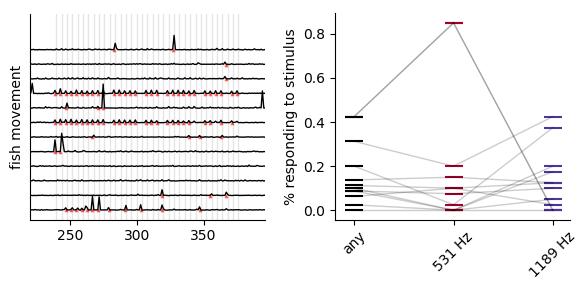

In [460]:
i = 7
ctr = 0
rows,cols = 1,2
figure(figsize=(cols*3,rows*3))


ax1 = subplot(rows,cols,1)
yticks([])
for s in stimtimes
    axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
end
ylabel("fish movement")
xlim(block_edges[1,1]-fps*5,block_edges[1,2]+fps*5)

ax2 = subplot(rows,cols,2)
ylabel("% responding to stimulus")
xticks([1,2,3],["any","531 Hz","1189 Hz"],rotation=45)

i =1
for i = 1:n_fish
    total_stim, responses, f1_resp, f2_resp = 0,0,0,0

    subplot(rows,cols,1)
    signal = diff(motion_reg[i][:])
    signal[signal.<-0.001] .= 0
    plot(signal.+ctr,color="black",linewidth=1)
    for s in vcat(f1_times,f2_times)
        total_stim += 1
        segment = signal[s-1:s+2]
        if maximum(segment) > 0.005
            responses += 1
            idx = findall(segment .== maximum(segment))[1]
            scatter(s-1,-0.001.+ctr,color="red",marker="^",s=3,alpha=0.5)
            
            if s in f1_times
                f1_resp += 1
            end
            if s in f2_times
                f2_resp += 1
            end
            
        end
    end
    ctr+=0.05

    subplot(rows,cols,2)
    scatter(1,responses/total_stim,color="black",marker="_",s=150)
    scatter(2,f1_resp/40,color=colors[3],marker="_",s=150)
    scatter(3,f2_resp/40,color=colors[4],marker="_",s=150)
    
    plot([1,2],[responses/total_stim,f1_resp/40],color="black",linewidth=1,alpha=0.2)
    plot([2,3],[f1_resp/40,f2_resp/40],color="black",linewidth=1,alpha=0.2)

end

for ax in [ax1,ax2]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

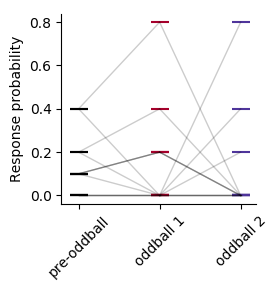

In [496]:
i = 7
ctr = 0
rows,cols = 1,2
figure(figsize=(cols*2.5,rows*3))


#ax1 = subplot(rows,cols,1)
#yticks([])
#for s in stimtimes
#    axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
#end
#ylabel("fish movement")
#xlim(block_edges[1,1]-fps*5,block_edges[1,2]+fps*5)

ax2 = subplot(rows,cols,1)
ylabel("Response probability")
xticks([1,2,3],["pre-oddball","oddball 1","oddball 2"],rotation=45)

reference_stim = vcat(oddball_times,ms_f1_times,ms_f2_times)

pre_all = []
f1_all = []
f2_all = []

ob1_resp = zeros(n_fish,length(oddball_1st))
ob2_resp = zeros(n_fish,length(oddball_2nd))

for i = 1:n_fish
    total_stim, responses, f1_resp, f2_resp = 0,0,0,0
    subplot(rows,cols,1)
    signal = diff(motion_reg[i][:])
    signal[signal.<-0.001] .= 0
    ob1_n = 0
    ob2_n = 0
    for s in vcat(oddball_1st,oddball_2nd)#stimtimes[1:end-1]
        segment = signal[s-1:s+2]
        sp = s - isi
        pre_segment = signal[sp-1:sp+2]
        total_stim +=1 
        if s in oddball_1st 
            ob1_n +=1 
        end
        if s in oddball_2nd 
            ob2_n +=1 
        end
        if maximum(segment) > 0.005
            idx = findall(segment .== maximum(segment))[1]
            responses += 1
            if s in oddball_1st
                f1_resp += 1
                ob1_resp[i,ob1_n] = 1
            end
            if s in oddball_2nd
                f2_resp += 1
                ob2_resp[i,ob2_n] = 1
            end     
        end
    end
    ctr+=0.05

    f1_resp = f1_resp/5
    f2_resp = f2_resp/5
    responses = responses/total_stim
    
    push!(pre_all,responses)
    push!(f1_all,f1_resp)
    push!(f2_all,f2_resp)
    
    subplot(rows,cols,1)
    
    scatter(1,responses,color="black",marker="_",s=150)
    scatter(2,f1_resp,color=colors[3],marker="_",s=150)
    scatter(3,f2_resp,color=colors[4],marker="_",s=150)
    
    plot([1,2],[responses,f1_resp],color="black",linewidth=1,alpha=0.2)
    plot([2,3],[f1_resp,f2_resp],color="black",linewidth=1,alpha=0.2)
end

for ax in [ax1,ax2]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

### Response probability by centroid

## Figure 1 - all dF/F with stimulus times

In [41]:
n_timepoints = length(DF[1,:])
x = collect(1:n_timepoints)./fps   
IJulia.clear_output()

0

In [587]:
x_ticks = collect(1:n_frames)[1:60:end].- 0.25

x_labels = x[1:60:end].- 0.25

19-element Vector{Float64}:
   0.0
  15.0
  30.0
  45.0
  60.0
  75.0
  90.0
 105.0
 120.0
 135.0
 150.0
 165.0
 180.0
 195.0
 210.0
 225.0
 240.0
 255.0
 270.0

### Frequency selective cells dF/F

### Change in df/F for individual animals (scatter plot)

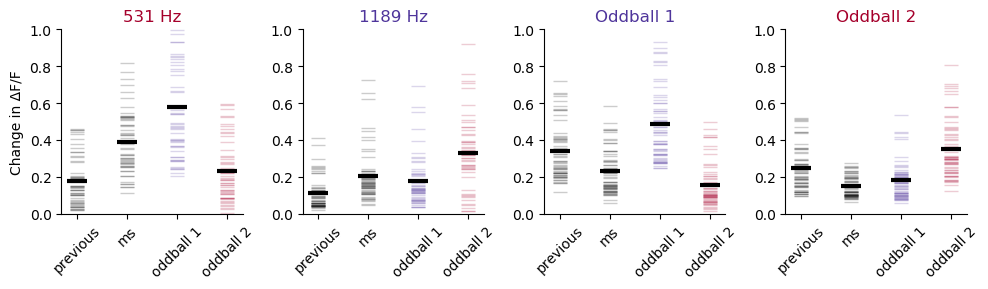

In [644]:
r = 11

rows,cols = 1,4

figure(figsize=(cols*2.5,rows*3))

ax1 = subplot(rows,cols,1)
ylabel("Change in ΔF/F")
ax2 = subplot(rows,cols,2)
ax3 = subplot(rows,cols,3)
ax4 = subplot(rows,cols,4)

stim_freq = [0,1,1,0]
ms_times = [ms_f1_times,ms_f2_times,ms_f2_times,ms_f1_times]
c_ctr = 1
    avgs = zeros((4,2))

for r in [5,6,11,12]
    avgs = zeros((4,2))
    for fish in unique(idx_fish)
        valid_idx = findall(idx_fish[1,:] .== fish)
        sr = sig_rois[r,:][1]
        df_per_fish = intersect(sr,valid_idx)

        subplot(rows,cols,c_ctr)
        for t in 2:length(stimtimes)
            onset = stimtimes[t]
            response = vec(mean(DF[df_per_fish,onset:onset+isi],dims=1))
            response = sum(response) .- response[1]
            if stim_seq[t] .== stim_freq[c_ctr]
                if (stimtimes[t] in oddball_times)
                    resp = vec(mean(DF[df_per_fish,onset-isi:onset-1],dims=1))
                    resp = sum(resp) .- resp[1]
                    if (isnan(resp) == false)
                        avgs[1,1] += 1
                        avgs[1,2] += resp
                    end
                    scatter(1,resp,linewidth=1,alpha=0.2,color="black",marker="_",s=100)
                elseif ((onset in oddball_times) .== false) .&& ((onset in ms_times[c_ctr]) .== true)
                    scatter(2,response,linewidth=1,alpha=0.2,color="black",marker="_",s=100)
                    if (isnan(response) == false)
                        avgs[2,1] += 1
                        avgs[2,2] += response
                    end
                end
            end
            
            if (stimtimes[t] in oddball_1st) == true
                scatter(3,response,linewidth=1,alpha=0.2,color=colors[4],marker="_",s=100)
                if (isnan(response) == false)
                    avgs[3,1] += 1
                    avgs[3,2] += response
                end
            end
            
            if (stimtimes[t] in oddball_2nd) == true
                scatter(4,response,linewidth=1,alpha=0.2,color=colors[3],marker="_",s=100)
                if (isnan(response) == false)
                    avgs[4,1] += 1
                    avgs[4,2] += response
                end
            end
            
        end
    end
    
    for i = 1:4
        y = avgs[i,2]./avgs[i,1]
        scatter(i,y,color="black",s=200,marker="_",linewidth=3)
    end
    c_ctr += 1
end
    
titles = ["531 Hz","1189 Hz","Oddball 1","Oddball 2"]
title_cols = [colors[3],colors[4],colors[4],colors[3]]
ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(0,1)
    ax.set_title(titles[ctr],color=title_cols[ctr])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(["previous","ms","oddball 1", "oddball 2"],rotation=45)
    ctr+=1
end

tight_layout()

In [66]:
new = mean(avgs,dims=1)

1×5 Matrix{Float64}:
 0.0  0.167405  0.324175  0.350412  0.34047

In [65]:
avgs

4×5 Matrix{Float64}:
 0.0   0.363599    0.59329    0.632298    0.690891
 0.0  -0.00824763  0.0312484  0.0456423   0.0150574
 0.0  -0.0493322   0.0788736  0.0914098  -0.0349609
 0.0   0.363599    0.59329    0.632298    0.690891

### Proportion of ROIs per fish

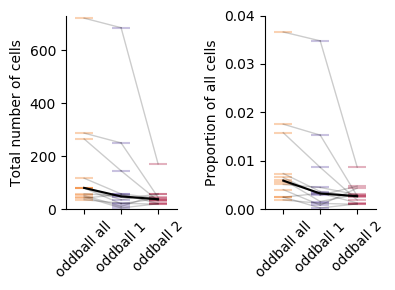

In [102]:
curr_cols = [colors[1],colors[4],colors[3]]

figure(figsize=(4,3))

ax1 = subplot(121)
ax2 = subplot(122)

rs = [2,11,12]

avgs = zeros((3,n_fish,2))
fish_ctr = 1
for fish in unique(idx_fish)
    ctr = 1
    for r = 1:3
        valid_idx = findall(idx_fish[1,:] .== fish)
        sr = sig_rois[rs[r],:][1]
        df_per_fish = intersect(sr,valid_idx)
        total_n = length(df_per_fish)
        proportion = total_n/length(valid_idx)
        
        avgs[r,fish_ctr,1] += total_n
        avgs[r,fish_ctr,2] += proportion
        subplot(1,2,1)
        
        if ctr < 3
            nsr = sig_rois[rs[r+1],:][1]
            ndf_per_fish = intersect(nsr,valid_idx)
            nproportion = length(ndf_per_fish)
            plot([ctr,ctr+1],[total_n,nproportion],color="black",linewidth=1,alpha=0.2)
        end
        scatter(ctr,total_n,color=curr_cols[ctr],marker="_",s=150,alpha=0.3)
        
        subplot(1,2,2)
        
        if ctr < 3
            nsr = sig_rois[rs[r+1],:][1]
            ndf_per_fish = intersect(nsr,valid_idx)
            nproportion = length(ndf_per_fish)./length(valid_idx)
            plot([ctr,ctr+1],[proportion,nproportion],color="black",linewidth=1,alpha=0.2)
        end
        scatter(ctr,proportion,color=curr_cols[ctr],marker="_",s=150,alpha=0.3)

        ctr+=1
        if(proportion) > 500 print(fish) end
    end
    fish_ctr+=1
end

medians = median(avgs[:,:,:],dims=2)
for s = 1:2
    subplot(1,2,s)
    plot(collect(1:3),vec(medians[:,:,s]),color="black")
end


for ax in [ax1,ax2]
    ax.set_xlim(0.5,3.5)
    #ax.set_ylim(0,1)
    #ax.set_title(titles[ctr],color=title_cols[ctr])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(["oddball all","oddball 1","oddball 2"],rotation=45)
    ctr+=1
end

ax1.set_ylabel("Total number of cells")
ax1.set_ylim(0,730)
ax2.set_ylabel("Proportion of all cells")
ax2.set_ylim(0,0.04)

tight_layout()

## Z Brain masks

In [28]:
mask_f = matopen(drv*"masks/Zbrain_Masks.mat","r")
masks=read(mask_f,"Zbrain_Masks")
close(mask_f)

In [56]:
masks[4,:][2]

"Caudal Hypothalamus"

In [45]:
n_masks = size(masks)[1]

295

19-element Vector{Float64}:
 946.0
 346.0
 957.0
 287.0
 945.0
 344.0
 934.0
 947.0
 963.0
 279.0
 335.0
 282.0
 342.0
 281.0
 347.0
 336.0
 339.0
 343.0
 291.0

In [74]:
findall(centroids .== coords,dims=1)

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 186675 and 5938")

In [69]:
region = 1
reg_name = masks[region,:][2]
coords = floor.(masks[region,:][3])

for roi = 1:total_rois
    x,y,z = floor.(centroids[roi,1]),floor.(centroids[roi,2]),floor.(centroids[roi,3])
    dims = intersect(centroids, coords)
   # if (floor.(centroids[1,:]) in coords) == true
   #     print(reg_name)
    #end

end

In [ ]:
for curr_reg in 1:n_masks
    #reg_name = masks[region,:][2]
    coords = floor.(masks[region,:][3])
    scatter(coords[
end

In [112]:
medians = vec(std(avgs[:,:,:],dims=2)[:,:,1])

3-element Vector{Float64}:
 196.61474019158902
 191.8633509937358
  40.74858242561291

In [108]:
minimum(avgs[3,:,1])

19.0

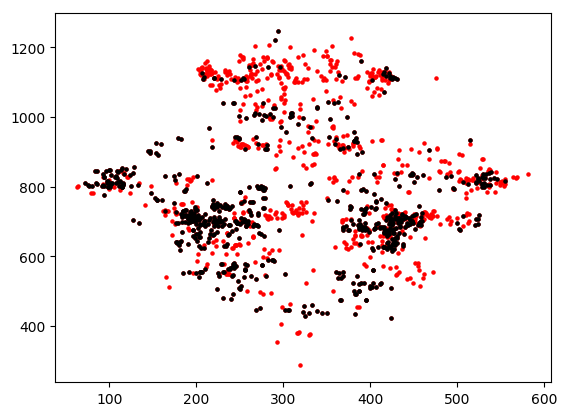

PyObject <matplotlib.collections.PathCollection object at 0x7fa38d1ffb70>

In [42]:
#for fish in unique(idx_fish)
fish = 7.0
valid_idx = findall(idx_fish[1,:] .== fish)
sr = sig_rois[11,:][1]
df_per_fish = intersect(sr,valid_idx)

scatter(centroids[sr,2],centroids[sr,1],color="red",s=5)
scatter(centroids[df_per_fish,2],centroids[df_per_fish,1],color="black",s=5)


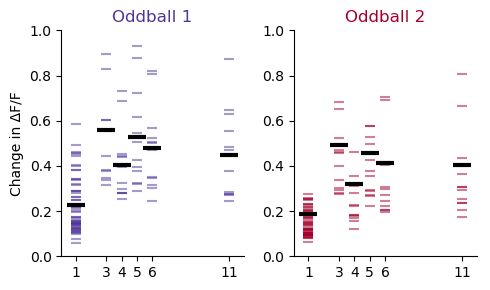

In [624]:
rows,cols = 1,2
figure(figsize=(2.5*cols,3*rows))

ax1 = subplot(rows,cols,1)
ax1.set_ylabel("Change in ΔF/F")
ax2 = subplot(rows,cols,2)

stim_freq = [0,1,1,0]
c_ctr = 1
title_cols = [colors[4],colors[3]]

repetitions = []
possible_repeats = sort([1,5,3,6,4,11])
repetitions = zeros(length(possible_repeats),2)

ob_times = [oddball_1st,oddball_2nd]
ms_times = [ms_f2_times,ms_f1_times]

for r in [11,12]
    for fish in unique(idx_fish)
        valid_idx = findall(idx_fish[1,:] .== fish)
        sr = sig_rois[r,:][1]
        df_per_fish = intersect(sr,valid_idx)

        subplot(rows,cols,c_ctr)
        #print(c_ctr)
        stims = vcat(ob_times[c_ctr],ms_times[c_ctr])
        for t in 2:length(stimtimes)
            onset = stimtimes[t]
            if (onset in stims) == true
                response = vec(mean(DF[df_per_fish,onset:onset+isi],dims=1))
                response = sum(response) .- response[1]
                prev_stim = stim_seq[t-1]
                curr_stim = stim_seq[t]

                repeats = findfirst(reverse(stim_seq[1:t-2]) .!== prev_stim)
                if isnothing(repeats) == true repeats = 11 end

                r_idx = findall(possible_repeats .== repeats)

                if (isnan(response) == false)
                    repetitions[r_idx,1] .+= 1
                    repetitions[r_idx,2] .+= response
                else 
                    print(repeats)
                end
                scatter(repeats,response,alpha=0.5,color=title_cols[c_ctr],s=50,marker="_")
                #end
            end
        end
    end
    
    for i = 1:size(repetitions)[1]
        y = repetitions[i,2]./repetitions[i,1]
        scatter(possible_repeats[i],y,color="black",s=150,marker="_",linewidth=3)
    end
    
    c_ctr += 1
end
    
titles = ["Oddball 1","Oddball 2"]
ctr = 1
for ax in [ax1,ax2]#,ax3,ax4]
    ax.set_ylim(0,1)
    ax.set_title(titles[ctr],color=title_cols[ctr])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    #ax.set_xlabel("previous stim repetition")
    ax.set_xticks(possible_repeats)
    #ax.set_xticklabels(["same","different","oddball 1", "oddball 2"],rotation=45)
    ctr+=1
end

tight_layout()

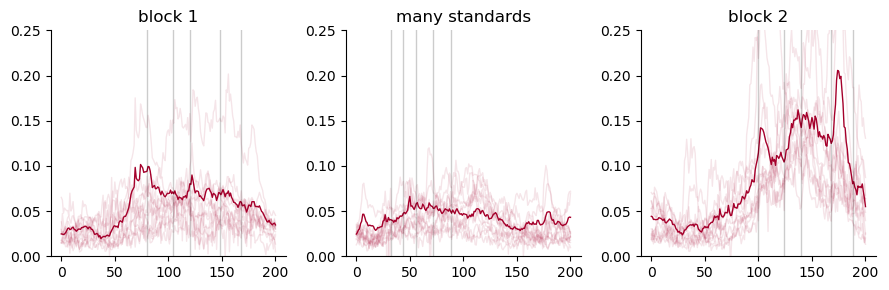

In [173]:
figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

titles = ["oddball","offset"]

n_fish = length(unique(idx_fish))

rngs = [200,600,900]

r = 12

#fish=unique(idx_fish)[1]
idx = findall(centroids[:,1] .> 1000)
for fish in unique(idx_fish)
    valid_idx = findall(idx_fish[1,:] .== fish)
    sr = sig_rois[r,:][1]
    or = sig_rois[r2,:][1]
    
    sr = intersect(sr,idx)

    df_per_fish = intersect(sr,valid_idx)
    for t = 1:3
        subplot(1,3,t)
        rng=rngs[t]:rngs[t]+200
        try
            avg = vec(mean(DF[df_per_fish,rng],dims=1))
            plot(avg,color=colors[3],linewidth=1,alpha=0.1)
        catch err
            print(err)
        end
    end
end

for t = 1:3
    subplot(1,3,t)
    rng=rngs[t]:rngs[t]+200
    sr = intersect(idx,sig_rois[r,:][1])
    avg = vec(mean(DF[sr,rng],dims=1))
    plot(avg,color=colors[3],linewidth=1)    
    for ob in oddball_times[(oddball_times .> rngs[t]) .&& (oddball_times .< rngs[t] + 200)]
        axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
    end
end

t = 2
subplot(1,3,t)
for ob in f1_times[(f1_times .> rngs[t]) .&& (f1_times .< rngs[t] + 200)]
    axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
end

subplot(131); title("block 1")
subplot(132); title("many standards")
subplot(133); title("block 2")

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,0.25)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

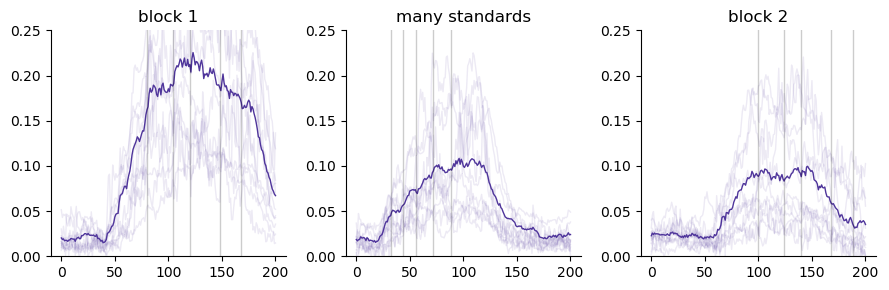

In [158]:
figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

titles = ["oddball","offset"]

n_fish = length(unique(idx_fish))

rngs = [200,600,900]

r = 11

#fish=unique(idx_fish)[1]
idx = findall(centroids[:,1] .> 1000)
for fish in unique(idx_fish)
    valid_idx = findall(idx_fish[1,:] .== fish)
    sr = sig_rois[r,:][1]
    or = sig_rois[r2,:][1]
    
    sr = intersect(sr,idx)

    df_per_fish = intersect(sr,valid_idx)
    for t = 1:3
        subplot(1,3,t)
        rng=rngs[t]:rngs[t]+200
        try
            avg = vec(mean(DF[df_per_fish,rng],dims=1))
            plot(avg,color=colors[4],linewidth=1,alpha=0.1)
        catch err
            print(err)
        end
    end
end

for t = 1:3
    subplot(1,3,t)
    rng=rngs[t]:rngs[t]+200
    sr = intersect(idx,sig_rois[r,:][1])
    avg = vec(mean(DF[sr,rng],dims=1))
    plot(avg,color=colors[4],linewidth=1)    
    for ob in oddball_times[(oddball_times .> rngs[t]) .&& (oddball_times .< rngs[t] + 200)]
        axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
    end
end

t = 2
subplot(1,3,t)
for ob in f1_times[(f1_times .> rngs[t]) .&& (f1_times .< rngs[t] + 200)]
    axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
end

subplot(131); title("block 1")
subplot(132); title("many standards")
subplot(133); title("block 2")

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,0.25)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

### Plot average DF/F for oddball cells that are NOT also frequency responsive

# Cover traces

In [46]:
reg_titles

10-element Vector{String}:
 "auditory"
 "oddball"
 "oddball_offset"
 "random"
 "freq1"
 "freq2"
 "ob_1st"
 "ob_2nd"
 "ob_1st_offset"
 "ob_2nd_offset"

In [156]:
idxs = [54, 845, 883, 890, 929, 1839, 2185, 2392, 2592, 2750, 3027, 3097, 3176, 3697, 3731, 3852, 3888, 3915, 3935, 4066, 4268, 4814, 4829, 4861, 4903, 4988, 5090, 5205, 5430, 5685, 5911, 6017, 6079, 6125, 6199, 6542, 6595, 6631, 6746, 7017, 7032, 7403, 7567, 7574, 7726, 7885, 8432, 8612, 9143, 10676, 15516, 15865, 16028, 16170, 16280, 16859, 20857, 22159, 22394, 22838, 22852, 22968, 23182, 23580, 23731, 23753, 23787, 23850, 23907, 23938, 24158, 24327, 24332, 24561, 24575, 24662, 24710, 24722, 25052, 25107, 25514, 25912, 26072, 26459, 27378, 37065, 37145, 37183, 37207, 37224, 37290, 37298, 37565, 37855, 37859, 37905, 38030, 38071, 38097, 38106, 38388, 38637, 38638, 38987, 39084, 39349, 39428, 39598, 40144, 41397, 43472, 43483, 44564, 44741, 44898, 47480, 50984, 51068, 51270, 51435, 51493, 51521, 51616, 52179, 53382, 53784, 54101, 62461, 64996, 66708, 66985, 67441, 67668, 68837, 81005, 82064, 82117, 82295, 82636, 82829, 82942, 83402, 83503, 85648, 96764, 96855, 96878, 97132, 97316, 97870, 97912, 97968, 97985, 98102, 98279, 98457, 98816, 98951, 98973, 99448, 99655, 99731, 99764, 100097, 100111, 100290, 100391, 100549, 100765, 100876, 100998, 101061, 101231, 101324, 101433, 101458, 101981, 102184, 102292, 102451, 102474, 102537, 102680, 102693, 102776]
idxs[24]

4861

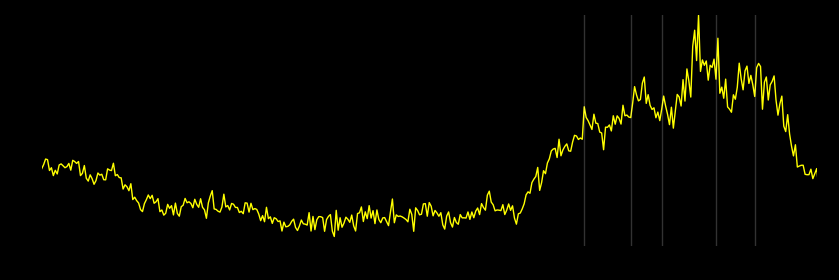

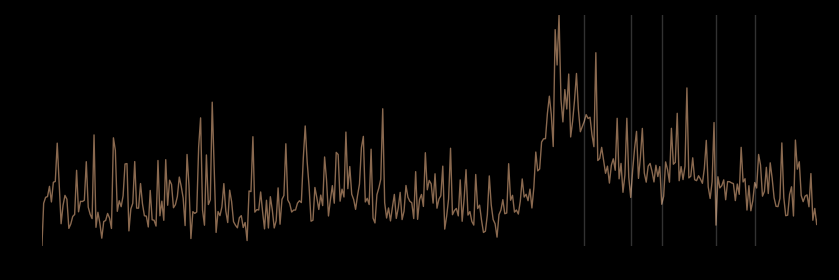

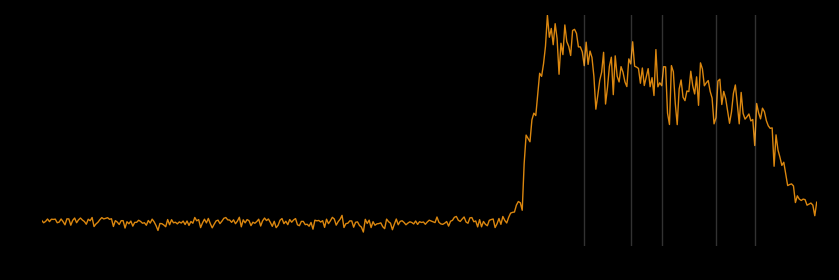

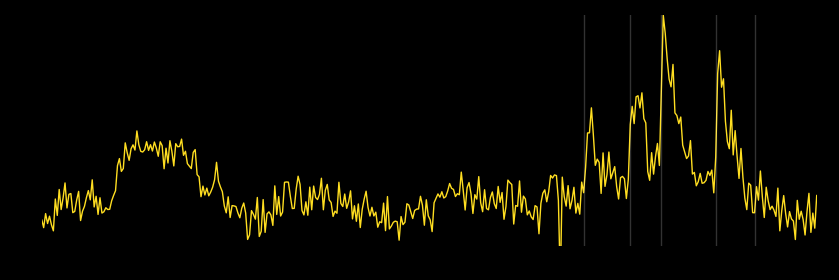

In [187]:
 #axis("off")

#oddball, tectum, auditory1, auditory 2
idx_list = ([4861,35,5163,15807])
PyPlot.plt.style.use("dark_background")
colors = ["yellow",[0.54,0.41,0.31],[0.86,0.53,0.06],[1,0.87,0.13]]
ctr = 1
y_adj = 1
for idx in idx_list
    figure(figsize=(10,3))

    ax = subplot(111);
    #subplot(4,1,5-ctr);
    trace = DF[idx,:]./maximum(DF[idx,:])
    plot(trace,linewidth=1,color=colors[ctr])
    ctr+=1
    
    axis("off")
    ylim(-0.1,1)
    for ob in oddball_1st#[(f1_times .> 200) .&& (f2_times .< 400)]
        axvline((ob),0,1,color="white",linewidth=1,alpha=0.2)
    end
    xlim(0,400)
end

#for sp = 1:4
#    subplot(4,1,sp)

#end

    
xlim(1,400)
ax.set_facecolor("black")

In [169]:
    trace = DF[idx,:]./maximum(DF[idx,:])
    plot(trace.+(y_adj*ctr),linewidth=1,color=colors[4])

Figure(PyObject <matplotlib.figure.Figure object at 0x7fc99d46b3c8>)

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc99c8afef0>

In [163]:
scatter(1,2,color=colors[2])

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/stednitz/.julia/packages/PyCall/L0fLP/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError("'color' kwarg must be an mpl color spec or sequence of color specs.\nFor a sequence of values to be color-mapped, use the 'c' kwarg instead.",)
  File "/usr/lib/python3/dist-packages/matplotlib/pyplot.py", line 3378, in scatter
    edgecolors=edgecolors, data=data, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/__init__.py", line 1718, in inner
    return func(ax, *args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py", line 3915, in scatter
    raise ValueError("'color' kwarg must be an mpl color"


In [101]:
idxs[24]

4861

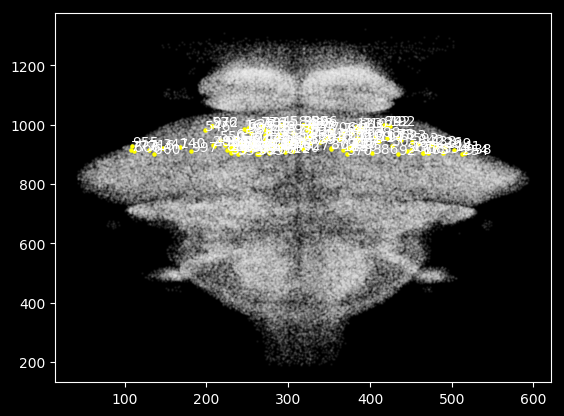

8, 16, 19, 21, 23, 28, 35, 44, 50, 58, 69, 74, 78, 92, 101, 110, 112, 117, 123, 139, 140, 141, 175, 177, 192, 206, 211, 226, 232, 237, 244, 246, 254, 266, 267, 273, 289, 310, 312, 333, 346, 347, 353, 359, 363, 370, 379, 386, 388, 422, 424, 428, 438, 457, 458, 461, 479, 489, 496, 509, 511, 520, 523, 536, 538, 539, 541, 546, 550, 554, 572, 589, 593, 599, 603, 627, 630, 633, 637, 647, 653, 658, 660, 663, 666, 687, 706, 714, 715, 716, 761, 771, 772, 776, 777, 787, 793, 799, 812, 818, 821, 826, 830, 835, 842, 857, 867, 880, 892, 906, 910, 912, 921, 936, 938, 945, 954, 955, 967, 969, 972, 986, 993, 997, 

In [141]:
scatter(centroids[:,2],centroids[:,1],color="white",s=1,alpha=0.05)#nsa)

idx = sig_rois[6,:][1][190]
for idx in nonsig_rois[1,:][1][1:1000]

#idx = sig_rois[11,:][1][1000]
#idx = 2592
if centroids[idx,1] > 900 && centroids[idx,1] < 1000 
    scatter(centroids[idx,2],centroids[idx,1],color="yellow",s=5,alpha=1)
    text(centroids[idx,2],centroids[idx,1],idx)
    print("$idx, ")
end
end

### Intersection anatomy plots

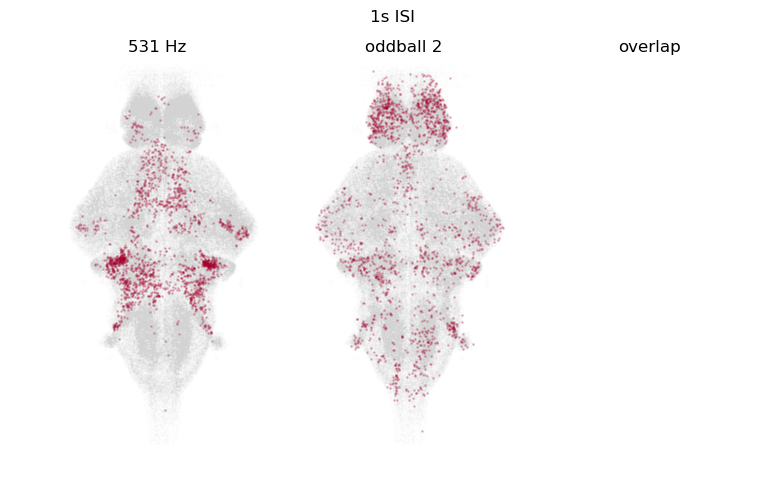

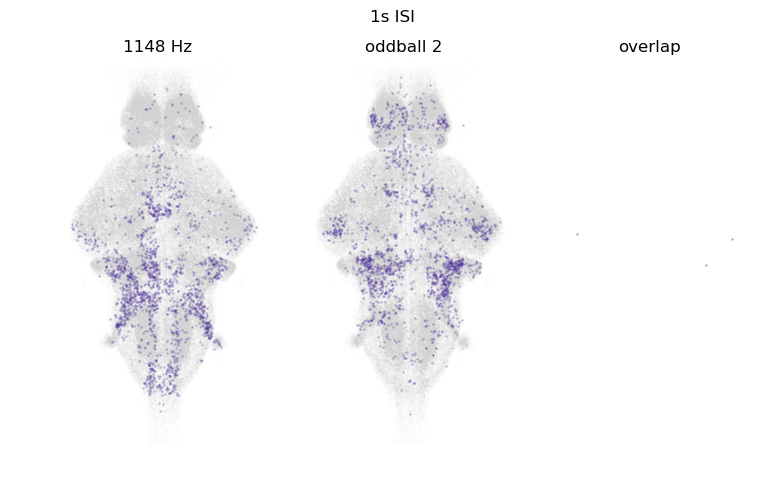

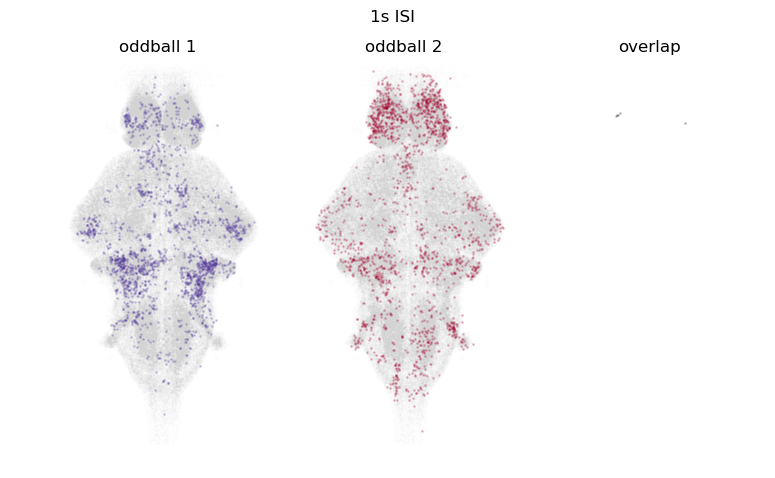

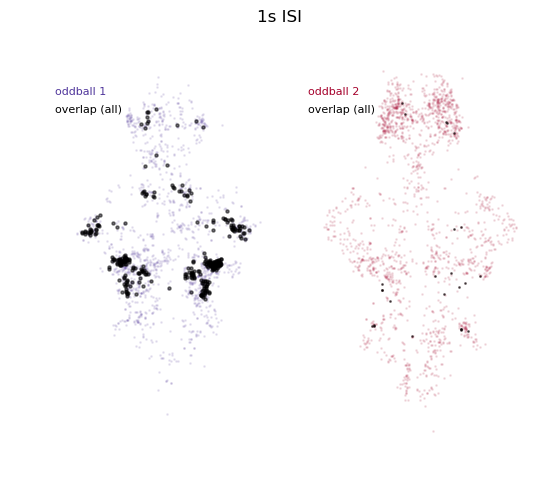

In [778]:
figure(figsize=(9,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["531 Hz","oddball 2","overlap"]

nr2 = nonsig_rois[5,:][1]; sr2 = sig_rois[5,:][1]
nr3 = nonsig_rois[8,:][1]; sr3 = sig_rois[8,:][1]
or = intersect(sr2,sr3)

ax2 = subplot(131);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)

ax3 = subplot(132);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ax4 = subplot(133);
scatter(centroids[or,2],centroids[or,1],color="black",s=1,alpha=a)

ctr = 1
for ax in [ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

figure(figsize=(9,5)); 
suptitle("1s ISI")
a = 0.2

titles = ["1148 Hz","oddball 1","overlap"]

nr2 = nonsig_rois[6,:][1]; sr2 = sig_rois[6,:][1]
nr3 = nonsig_rois[7,:][1]; sr3 = sig_rois[7,:][1]
or = intersect(sr2,sr3)

ax2 = subplot(131);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ax3 = subplot(132);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)

ax4 = subplot(133);
scatter(centroids[or,2],centroids[or,1],color="black",s=1,alpha=a)

ctr = 1
for ax in [ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

figure(figsize=(9,5)); 
suptitle("1s ISI")
a = 0.2

titles = ["oddball 1","oddball 2","overlap"]

nr2 = nonsig_rois[7,:][1]; sr2 = sig_rois[7,:][1]
nr3 = nonsig_rois[8,:][1]; sr3 = sig_rois[8,:][1]
or = intersect(sr2,sr3)

ax2 = subplot(131);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ax3 = subplot(132);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ax4 = subplot(133);
scatter(centroids[or,2],centroids[or,1],color="black",s=1,alpha=a)

ctr = 1
for ax in [ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end


figure(figsize=(6,5)); 
suptitle("1s ISI")
a = 0.1

fs = 8
#titles = ["oddball 1/all oddball","oddball 2/all oddball",""]

nr1 = nonsig_rois[1,:][1]; sr1 = sig_rois[1,:][1]
nr2 = nonsig_rois[7,:][1]; sr2 = sig_rois[7,:][1]
nr3 = nonsig_rois[8,:][1]; sr3 = sig_rois[8,:][1]
or1 = intersect(sr1,sr2)
or2 = intersect(sr1,sr3)

ax2 = subplot(121);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)
scatter(centroids[or1,2],centroids[or1,1],color="black",s=5,alpha=0.5)
text(0,1200,"oddball 1",color=colors[4],fontsize=fs)
text(0,1150,"overlap (all)",color="black",fontsize=fs)


ax3 = subplot(122);
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)
scatter(centroids[or2,2],centroids[or2,1],color="black",s=1,alpha=0.5)
text(0,1200,"oddball 2",color=colors[3],fontsize=fs)
text(0,1150,"overlap (all)",color="black",fontsize=fs)

ctr = 1
for ax in [ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ctr+=1
end

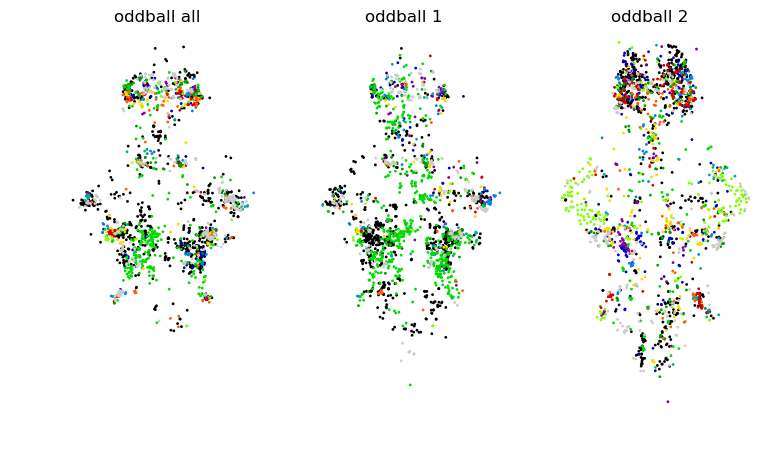

In [797]:
figure(figsize=(9,5))

cm = "nipy_spectral"

sr =  sig_rois[2,:][1]
sr1 = sig_rois[7,:][1]
sr2 = sig_rois[8,:][1]

ax1 = subplot(131); title("oddball all")
scatter(centroids[sr,2],centroids[sr,1],c=reset_idx_fish[sr]/n_fish,s=1,cmap=cm)

ax2 = subplot(132); title("oddball 1")
scatter(centroids[sr1,2],centroids[sr1,1],c=reset_idx_fish[sr1]/n_fish,s=1,cmap=cm)

ax3 = subplot(133); title("oddball 2")
scatter(centroids[sr2,2],centroids[sr2,1],c=reset_idx_fish[sr2]/n_fish,s=1,cmap=cm)

for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
end

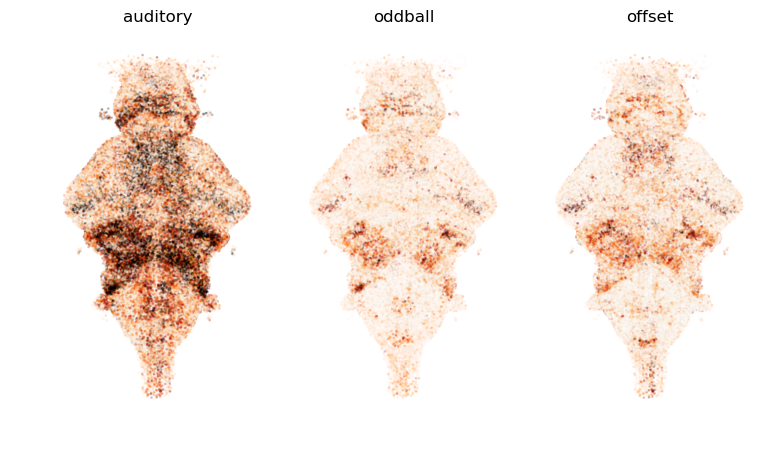

PyObject <matplotlib.collections.PathCollection object at 0x7f7ff7dbe860>

In [394]:
figure(figsize=(9,5)); 
a = 0.2
vm = 0.2

subplot(131); axis("off"); title("auditory")
scatter(centroids[:,2],centroids[:,1],c=r2s[1,:],cmap="gist_heat_r",s=1,alpha=a,vmin=0,vmax=vm)

subplot(132); axis("off"); title("oddball")
scatter(centroids[:,2],centroids[:,1],c=r2s[2,:],cmap="gist_heat_r",s=1,alpha=a,vmin=0,vmax=vm)

subplot(133); axis("off"); title("offset")
scatter(centroids[:,2],centroids[:,1],c=r2s[3,:],cmap="gist_heat_r",s=1,alpha=a,vmin=0,vmax=vm)

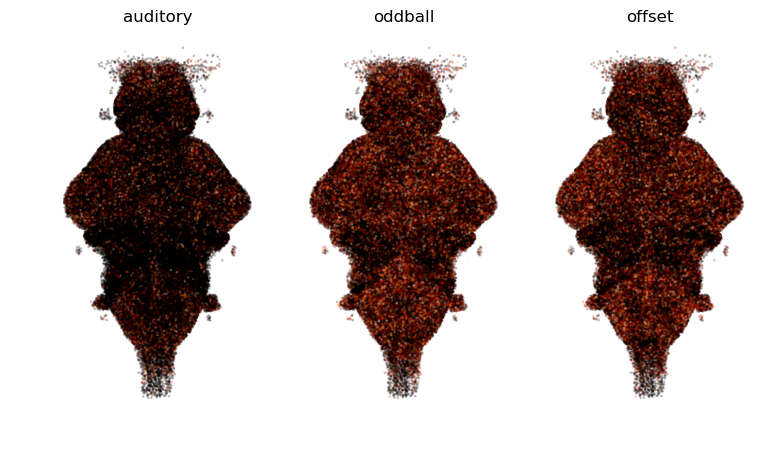

PyObject <matplotlib.collections.PathCollection object at 0x7f7ff9043b00>

In [410]:
figure(figsize=(9,5)); 

a = 0.2
vm = 1

cm = "gist_heat"

subplot(131); axis("off"); title("auditory")
scatter(centroids[:,2],centroids[:,1],c=pvals[1,:],cmap=cm,s=1,alpha=a,vmin=0,vmax=vm)

subplot(132); axis("off"); title("oddball")
scatter(centroids[:,2],centroids[:,1],c=pvals[2,:],cmap=cm,s=1,alpha=a,vmin=0,vmax=vm)

subplot(133); axis("off"); title("offset")
scatter(centroids[:,2],centroids[:,1],c=pvals[3,:],cmap=cm,s=1,alpha=a,vmin=0,vmax=vm)

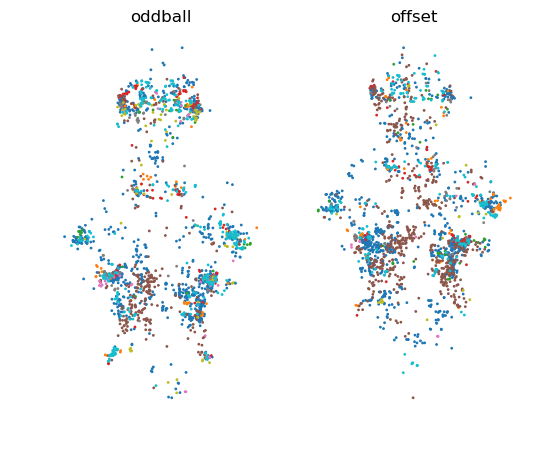

PyObject <matplotlib.collections.PathCollection object at 0x7f801dc95438>